# Тренд-репорт на основе исследовательского анализа данных

1. [Описание и цели](#objectives)
2. [Обзор и предобработка данных](#preprocessing)
    * [Обзор групп признаков](#features)    
    * [Характеристики респондентов](#main_features)
    * [Группы признаков DesignStyle](#features_ds)
    * [Набор признаков LifeStyle](#features_ls)
    * [Результаты предобработки данных](#summary_preprocessing)
    
    
3. [Исследовательский анализ данных EDA](#eda)
4. [Кластерный анализ](#clustering)
    * [Выбор оптимального числа кластеров](#cluster_number)
    * [Сравнение кластерных групп](#compare_clusters)   
5. [Вывод и рекомендации](#summary)

## Описание и цели<a id="objectives"></a>

Дизайн студия путем анкетирования респондентов собрала данные о предпочтениях целевой аудитории. На основе их исследования будет сформирован тренд-репорт об актуальных трендах и тенденциях следующего сезона в области fashion, beauty и interior design.

Цели проекта:

- Провести исследовательский анализ признаков визуального восприятия DesignStyle, выявить основные элементы дизайна влияющие на отношение к тренду

- Провести сегментацию целевой аудитории по признакам жизненных ценностей LifeStyle

- Выявить изменения восприимчивости к визуальным трендам среди разных ценностных классов

- Выявить основные элементы дизайна влияющие на отношение к тренду

Исходные данные:

- датасет с результатами анкетирования респондентов
- описание набора визуального контента с тегами для категории "Женщины"
- описание набора визуального контента с тегами для категории "Мамы"

## Обзор и предобработка данных<a id="preprocessing"></a>

In [1]:
#проверка и установка необходимых библиотек
import sys
import subprocess
import pkg_resources

required = {'pandas', 'pymystem3', 'seaborn', 'matplotlib', 'numpy', 'sklearn', 'scipy'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

In [2]:
#импорт библиотек
import pandas as pd
from pymystem3 import Mystem
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [3]:
#чтение файла с данными по опросам респондентов "base.sav"
path = ''
df = pd.read_spss(path+'base.sav')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063 entries, 0 to 1062
Columns: 3138 entries, InterviewID to rank2_70
dtypes: category(2982), float64(149), object(7)
memory usage: 4.6+ MB


In [5]:
#чтение файлов с тегами

#Описание картинок с тегами, показанных категории "Женщины"
women_tags = pd.read_excel('women_tags.xlsx', index_col=0)
women_tags.head()

,eco1,eco2,eco3,eco4,eco4 (графитовый плащ),eco5,eco6,eco7,eco8,eco9,...,NaRai9,lek1,lek2,lek3,lek4,lek5,lek6,lek7,lek8,lek9
,,,,,,,,,,,,,,,,,,,,,
тренд,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
описание,Экология,экология,экология,экология,экология,экология,экология,экология,экология,экология,...,на районе,лекторий,лекторий,лекторий,лекторий,лекторий,лекторий,лекторий,лекторий,лекторий
силуэт,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
оверсайз,V,V,V,V,V,NaN,V,V,V,NaN,...,V,NaN,NaN,V,NaN,NaN,NaN,NaN,V,NaN
приталенный силуэт,V,NaN,NaN,NaN,NaN,V,NaN,NaN,NaN,V,...,NaN,NaN,NaN,NaN,V,V,NaN,V,NaN,NaN


In [6]:
#Описание картинок с тегами, показанных категории "Мамы" (файл переименован "дети теги.xlsx" --> "children_tags.xlsx")
children_tags = pd.read_excel(path+'children_tags.xlsx', index_col=0)
children_tags.head()

,4ern1,4ern2,4ern3,4ern4,4ern6,4ern7,uni1,uni2,uni3,uni4,...,jun5,jun6,jun7,bar1,bar2,bar3,bar4,bar5,bar6,bar7
,,,,,,,,,,,,,,,,,,,,,
тренд,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
описание,дарк-фешн,дарк-фешн,дарк-фешн,дарк-фешн,дарк-фешн,дарк-фешн,универсальность,универсальность,универсальность,универсальность,...,джунгли,джунгли,джунгли,лекторий,лекторий,лекторий,лекторий,лекторий,лекторий,лекторий
пол,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
девочка,V,NaN,NaN,NaN,V,NaN,V,V,NaN,NaN,...,V,V,V,V,NaN,V,NaN,V,V,V
мальчик,NaN,V,V,V,NaN,V,NaN,NaN,V,V,...,NaN,NaN,NaN,NaN,V,NaN,V,NaN,NaN,NaN


**Изучение основной базы с данными**

In [7]:
df.head()

,InterviewID,sex,age,AgeRange1,AgeRange2,CellCheck.1,CellCheck.2,CellGen,Cell.1,GroupCheck.1,...,rank2_61,rank2_62,rank2_63,rank2_64,rank2_65,rank2_66,rank2_67,rank2_68,rank2_69,rank2_70
0,20016954.0,Женский,24.0,20-24,18-24,Женщины,NaN,Женщины,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20017017.0,Женский,32.0,25-34,25-34,Женщины,Мамы,Мамы,2.0,NaN,...,0.788937,0.248524,1.337231,8.204173,0.248524,0.248524,0.248524,0.248524,0.131767,0.248524
2,20017185.0,Женский,38.0,35-44,35-44,Женщины,Мамы,Женщины,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20017197.0,Женский,38.0,35-44,35-44,Женщины,NaN,Женщины,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20017221.0,Женский,26.0,25-34,25-34,Женщины,NaN,Женщины,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# число уникальных респондентов
df['InterviewID'].nunique()

1063

**Вывод:**

В текущей таблице собраны ответы от 1063 респондентов. Таблица содержит более 3000 колонок.

До предобработки полей изучим признаки и определим их смысловые группы.

### Обзор признаков<a id="features"></a>

По данным заказчика исходный набор наблюдений содержит большое число избыточных технических данных. Нам необходимо определить группы признаков, отсечь неинформативные, оставив значимые для дальнейшего исследования.

In [9]:
# список названий колонок данных
df.columns

Index(['InterviewID', 'sex', 'age', 'AgeRange1', 'AgeRange2', 'CellCheck.1',
       'CellCheck.2', 'CellGen', 'Cell.1', 'GroupCheck.1',
       ...
       'rank2_61', 'rank2_62', 'rank2_63', 'rank2_64', 'rank2_65', 'rank2_66',
       'rank2_67', 'rank2_68', 'rank2_69', 'rank2_70'],
      dtype='object', length=3138)

In [10]:
#создадим таблицу с группами признаков
column_groups=[]
for column in df.columns:
    name = column.split('.')[0]
    column_groups.append(name.split('_')[0])

columns_data = pd.DataFrame(column_groups)
columns_data.columns=['feature']
columns_data.groupby('feature')['feature'].count().sort_values()

feature
AgeRange1      1
D10            1
D11            1
D3             1
D5             1
            ... 
AllDS2       143
AllDS1a      143
AllDS1       143
DS1a         715
DS1          715
Name: feature, Length: 63, dtype: int64

In [11]:
# функция поиска колонок в датафрейме по выбранной группе признаков
def columns_search(column_name):
    features = []
    for col in df.columns:
        if col.startswith(column_name):
            features.append(col)
    return features

**Вывод:** На первый взгляд таблица содержит избыточное число пересекающихся признаков респонентов (пол, статус родителя, пол детей и прочее). Продолжим изучение по группам признаков, основываясь на документ с описанием анкетирования.

### Основные характеристики респондентов <a id="main_features"></a>

Основываясь на предоставленном сопроводительном документе о структуре и последовательности опросов знаем, что каждый респондент был отнесен к определенной категориальной группе. При этом его принадлежность к той или иной группе опроса зависела от двух факторов:
1. ответов на предварительные вопросы (пол, возраст, наличие детей, их возраст и пр.)
2. наличие квоты в подходящей группе

Для исследовательского анализа результатов опроса нам нужно определить, к какой группе был отнесен респондент в соответсвии с квотами, а значит от избыточных колонок с ответами на предварительные вопросы можно будет избавиться.

Для предобработки основных характеристик респондентов изучим начальные колонки таблицы со смысловыми информативными названиями, а также признаки начинающиеся с 'S' (это ответы респондентов на скринер опроса).

In [12]:
# какие признаки Скринера опроса входят в датасет в колонках группы "S"
columns_search('S')

['S0',
 'S1',
 'S4',
 'S5.1',
 'S6sex_1',
 'S6age_1',
 'S6sex_2',
 'S6age_2',
 'S6sex_3',
 'S6age_3',
 'S6sex_4',
 'S6age_4',
 'S6sex_5',
 'S6age_5',
 'S6sex_6',
 'S6age_6',
 'S6sex_7',
 'S6age_7',
 'S6sex_8',
 'S6age_8',
 'S6sex_9',
 'S6age_9',
 'S6sex_10',
 'S6age_10',
 'S6_1.1',
 'S6_1.2',
 'S6_1.3',
 'S6_1.4',
 'S6_1.5',
 'S6_1.6',
 'S6_2.1',
 'S6_2.2',
 'S6_2.3',
 'S6_2.4',
 'S6_2.5',
 'S6_2.6']

**Половая принадлежность**

В таблице представлена только одна колонка гендерного признака 'sex' - это результаты ответов респондентов раздела Скринер опроса. Колонка с названием признака 'S2' отсутсвует.

In [13]:
# пол
df['sex'].unique()

[Женский]
Categories (1, object): [Женский]

Колонка "sex" не имеет пропусков, но является неинформативной для дальнейшего исследования, так как все респонденты женского пола.

In [14]:
# удаляем колонку 'sex'
try:
    df = df.drop('sex', axis=1)
except:
    print("Колонка уже удалена!")

In [15]:
df.head()

,InterviewID,age,AgeRange1,AgeRange2,CellCheck.1,CellCheck.2,CellGen,Cell.1,GroupCheck.1,GroupCheck.2,...,rank2_61,rank2_62,rank2_63,rank2_64,rank2_65,rank2_66,rank2_67,rank2_68,rank2_69,rank2_70
0,20016954.0,24.0,20-24,18-24,Женщины,NaN,Женщины,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20017017.0,32.0,25-34,25-34,Женщины,Мамы,Мамы,2.0,NaN,7-12 лет,...,0.788937,0.248524,1.337231,8.204173,0.248524,0.248524,0.248524,0.248524,0.131767,0.248524
2,20017185.0,38.0,35-44,35-44,Женщины,Мамы,Женщины,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20017197.0,38.0,35-44,35-44,Женщины,NaN,Женщины,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20017221.0,26.0,25-34,25-34,Женщины,NaN,Женщины,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Возрастные категории респондентов**

Возраст и возрастные категории обозначены в колонках: "age", "AgeRange1" и "AgeRange2"

In [16]:
# проверим пропуски в колонке "age"
df['age'].unique()

array([24., 32., 38., 26., 34., 25., 27., 31., 30., 42., 33., 36., 22.,
       20., 37., 40., 23., 39., 35., 43., 29., 41., 44., 28., 21., 19.])

In [17]:
# преобразование типа данных колонки "age" к целочисленному
df['age']=df['age'].astype('int')

In [18]:
df['AgeRange1'].unique()

[20-24, 25-34, 35-44, NaN]
Categories (3, object): [20-24, 25-34, 35-44]

В колонке "AgeRange1" есть пропущенные значения

In [19]:
df['AgeRange2'].unique()

[18-24, 25-34, 35-44]
Categories (3, object): [18-24, 25-34, 35-44]

In [20]:
# отберем срез возрастных категорий с пропущенными значениями в колонке "AgeRange1"
df[df['AgeRange1'].isnull()][['AgeRange1', 'AgeRange2', 'age']]

,AgeRange1,AgeRange2,age
741,NaN,18-24,19


Пропущенное значение у одного респондента в возрасте до 20 лет. Так как в опросе принимают участие только женщины в возрасте от 20 лет, то строку с пропущенным значением необходимо удалить.

In [21]:
# удаляем строку с пропущенным значением в категории возраста
df.drop(df[df.age < 20].index, inplace=True)

Так как в текущей выборке отсуствуют респонденты младше 20 лет, оставим только одну колонку с возрастной категорией респондента.

In [22]:
#удаляем столбец "AgeRange2"
try:
    df = df.drop('AgeRange2', axis=1)
except:
    print("Колонка уже удалена!")

In [23]:
#переименуем столбец "AgeRange1" в "AgeRange"
df.rename(columns=lambda x: x.replace('AgeRange1', 'AgeRange'), inplace=True)

In [24]:
df.head()

,InterviewID,age,AgeRange,CellCheck.1,CellCheck.2,CellGen,Cell.1,GroupCheck.1,GroupCheck.2,GroupGen,...,rank2_61,rank2_62,rank2_63,rank2_64,rank2_65,rank2_66,rank2_67,rank2_68,rank2_69,rank2_70
0,20016954.0,24,20-24,Женщины,NaN,Женщины,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20017017.0,32,25-34,Женщины,Мамы,Мамы,2.0,NaN,7-12 лет,7-12 лет,...,0.788937,0.248524,1.337231,8.204173,0.248524,0.248524,0.248524,0.248524,0.131767,0.248524
2,20017185.0,38,35-44,Женщины,Мамы,Женщины,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20017197.0,38,35-44,Женщины,NaN,Женщины,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20017221.0,26,25-34,Женщины,NaN,Женщины,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df['AgeRange'].unique()

[20-24, 25-34, 35-44]
Categories (3, object): [20-24, 25-34, 35-44]

**Вывод:** В возрастной категориальной переменной "AgeRange1" было найдено только одно пропущенное значение у единственного респондента младше 20 лет. Удалили строку пропущенным значением в возрастной категории.  Сократили количество колонок с категориальными данными о возрасте.

После преобразований в датасете возрастную категорию описывает один столбец - "AgeRange".

Возраст респондентов варьируется от 20 до 44 лет в 3х возрастных категориях:
- 20-24
- 25-34
- 35-44

**Категория "Женщины / Мамы"**

Признак наличия детей в возрасте от 3 до 12 лет в опросе определяется относением респондента к одной из 2 групп: "Женщины", "Мамы" (в описании респонденты относятся к "Ячейка 1"/"Ячейка 2").

В представленном датасете этот признак встречается в колонках "CellCheck.1", "CellCheck.2", "CellGen", "Cell.1"Б а также "S4"

In [26]:
# характеристика по возрасту и полу
df['CellCheck.1'].unique()

[Женщины]
Categories (1, object): [Женщины]

In [27]:
# характеристика категории "мамы" по ответам респондентов
df['CellCheck.2'].unique()

[NaN, Мамы]
Categories (1, object): [Мамы]

In [28]:
# итоговая категориальная переменная "Женщины"/"мамы" 
df['CellGen'].unique()

[Женщины, Мамы]
Categories (2, object): [Женщины, Мамы]

In [29]:
df['Cell.1'].unique()

array([1., 2.])

In [30]:
df.pivot_table(index='CellGen', columns ='Cell.1', values='InterviewID', aggfunc='count')

Cell.1,1.0,2.0
CellGen,,
Женщины,562.0,NaN
Мамы,NaN,500.0


Значения в колонках CellGen и Cell.1 совпадают, отображают одни и те же значения по респондентам, но в первой колонке в строком формате, а во втором закодировано в числовой переменной: 1 - "Женщины", 2 - "Мамы".  

In [31]:
# есть ли ребенок от 3 до 12 лет  - колонка "S4"
df.groupby(['S4'])['InterviewID'].count()

S4
Да     626
Нет    436
Name: InterviewID, dtype: int64

In [32]:
#количество "мам" по ответам респондентов
df['CellCheck.2'].count()

626

In [33]:
df.groupby(['S4', 'Cell.1'])['InterviewID'].count()

S4   Cell.1
Да   1.0       126
     2.0       500
Нет  1.0       436
     2.0         0
Name: InterviewID, dtype: int64

In [34]:
#переименуем столбец "Cell.1" в "Cell"
df.rename(columns=lambda x: x.replace('Cell.1', 'Cell'), inplace=True)

In [35]:
# преобразование типа данных колонки "Cell" к целочисленному
df['Cell']=df['Cell'].astype('int')

In [36]:
# удаляем "лишние" колонки признака наличия детей
try:
    df = df.drop(['CellCheck.1', 'CellCheck.2'], axis=1)
except:
    print("Не удаось удалить колонки!")

**Вывод:**

**"CellCheck.1"** - колонка со значением "Женщина" (по опросу данное значение заполняется у всех респондентов женского пола в возрасте от 20 до 55 лет). Мы определили, что в представленном датасете собраны данные респондентов от 20 до 44 лет, данное значение установлено у всех записей.

**"CellCheck.2"** - колонка со значением "Мамы" - установлено у тех, кто ответил положительно на вопрос о наличии детей от 3х до 12 лет. Пропуски - у всех респондентов, ответивших отрицательно.

**"S4"** - содержит ответы (Да/Нет) на вопрос о наличии детей.

**"CellGen" и "Cell.1"** - поля содержат значения категории: "Женщина"/"Мама" и 1/2 соотвественно.

Несоотвествие в количестве "Женщин-мам" в разных колонках с данной характеристикой говорит о том, что респондентов-мам детей от 3 до 12 лет среди опрошенных изначально было на 30% больше, чем женщин, не имеющих детей в этой возрастной категории.

Приходим к выводу, что на группу "мамы" была установлена квота в размере 500 респондентов. Поэтому для опроса "лишние" мамы, были отнесены к ячейке "1 - Женщины" и не принимали участие в анкетировании в разделах вопросов, связанных с детьми.

**Итоговые значения категории "Женщины/мамы", которые были присвоены респондентам, находятся в колонках: "CellGen" и "Cell" (1 - женщина, 2 - мама)**

**Возрастные группы детей**

Представлены 4 колонки, определяющие возрастную категорию детей (у респондентов в категории "Мамы"):

In [37]:
df['GroupCheck.1'].unique()

[NaN, 3-6 лет]
Categories (1, object): [3-6 лет]

In [38]:
df['GroupCheck.2'].unique()

[NaN, 7-12 лет]
Categories (1, object): [7-12 лет]

In [39]:
df['GroupGen'].unique()

[NaN, 7-12 лет, 3-6 лет]
Categories (2, object): [7-12 лет, 3-6 лет]

In [40]:
df.pivot_table(index='GroupGen', columns ='Group.1', values='InterviewID', aggfunc='count')

Group.1,1.0,2.0
GroupGen,,
3-6 лет,255.0,NaN
7-12 лет,NaN,245.0


In [41]:
#переименуем столбец "Group.1" в "Group"
df.rename(columns=lambda x: x.replace('Group.1', 'Group'), inplace=True)

In [42]:
#заменим пропущенные значения в Group на '0' - нет детей
df['Group'].fillna(0, inplace=True)

In [43]:
# преобразование типа данных колонки "Cell" к целочисленному
df['Group']=df['Group'].astype('int')

In [44]:
#удаляем колонки с первичным вводом данных о принадлежности респондентов к возрастной категории детей
try:
    df = df.drop(['GroupCheck.1', 'GroupCheck.2'], axis=1)
except:
    print("Не удаось удалить колонки!")

**Вывод:** 

Признаки, определения возрастной категории детей:

**"GroupCheck.1"**  -  есть ли дети в категории 3-6 лет

**"GroupCheck.2"**  -  есть ли дети в категории 7-12 лет

**"GroupGen"** и **"Group.1"** - признаки группы, к которой отнесли респондента в соотвествии с имеющимися квотами. Group -  имеет числовые категориальные значения (0 - нет детей, 1 - дети 3-6 лет, 2 - дети 7-12 лет). 

**Колонки "ChooseGroup" и "KidSex"**

In [45]:
#проверяем есть ли пропуски в ChooseGroup, у категории "Мамы"
df.query('Cell == 2')['ChooseGroup'].unique()

[САМОСТОЯТЕЛЬНЫЙ ВЫБОР, ВЫБИРАЕТ МАМА]
Categories (2, object): [САМОСТОЯТЕЛЬНЫЙ ВЫБОР, ВЫБИРАЕТ МАМА]

In [46]:
df.query('Cell == 2')['KidSex'].unique()

[Woman, Man]
Categories (2, object): [Woman, Man]

**Вывод:** Пропуски в описательных колонках о детях не найдены среди выборки записей респондентов категории "Мама". В значении 'KidSex' указан пол того ребенка, который попал по квоте в возрастную группу для опроса.

In [47]:
column_groups=[]
for column in df.columns:
    #column_groups += column.split('.')
    name = column.split('.')[0]
    column_groups.append(name.split('_')[0])

columns_data = pd.DataFrame(column_groups)
columns_data.columns=['feature']

In [48]:
columns_data['feature'].value_counts()

DS1a               715
DS1                715
AllDS1a            143
AllDS3             143
AllDS2             143
AllDS1             143
Cell1ForScreen3     73
Cell1ForScreen1     73
Cell1ForScreen4     73
Cell1ForScreen2     73
Cell1ForScreen5     73
rank1               73
Cell2ForScreen3     70
Cell2ForScreen5     70
Cell2ForScreen4     70
rank2               70
Cell2ForScreen2     70
Cell2ForScreen1     70
C1                  42
C5                  21
C8                  19
LS2                 19
C9                  19
LS1                 19
C6                  15
DS3                 14
DS2                 14
IsOkay              12
S6                  12
N1                  11
S6age               10
S6sex               10
P0                   8
D8                   2
age                  1
S5                   1
D3                   1
D6                   1
D10                  1
S1                   1
S4                   1
Cell                 1
CellGen              1
D7         

**Обзор признаков Скринера (группа признаков S0-S6)** 

In [49]:
# города проживания респондентов
df.groupby('S0')['InterviewID'].count()

S0
Волгоград           27
Воронеж             27
Екатеринбург        46
Казань              45
Красноярск          17
Москва             475
Нижний Новгород     46
Новосибирск         60
Омск                27
Пермь               30
Ростов-на-Дону      29
Самара              55
Санкт-Петербург    120
Уфа                 38
Челябинск           20
Name: InterviewID, dtype: int64

In [50]:
# сфера деятельности респондентов
df.groupby('S1')['InterviewID'].count()

S1
Автомобильное производство        18
Ничего из вышеперечисленного    1044
Name: InterviewID, dtype: int64

In [51]:
# количество детей
df[columns_search('S5')]

,S5.1
0,NaN
1,1.0
2,NaN
3,NaN
4,NaN
...,...
1058,2.0
1059,2.0
1060,1.0
1061,1.0


In [52]:
df['S5.1'].unique()

array([nan,  1.,  2.,  3.,  4.,  9.])

In [53]:
# заменяем пропуски в поле количество детей на 0
df['S5.1'].fillna(0, inplace=True)

In [54]:
# преобразование типа данных колонки "Cell" к целочисленному
df['S5.1']=df['S5.1'].astype('int')

**Характеристики по полу и возрасту каждого ребенка**

In [55]:
# найдем все признаки-характеристики детей
columns_search('S6')

['S6sex_1',
 'S6age_1',
 'S6sex_2',
 'S6age_2',
 'S6sex_3',
 'S6age_3',
 'S6sex_4',
 'S6age_4',
 'S6sex_5',
 'S6age_5',
 'S6sex_6',
 'S6age_6',
 'S6sex_7',
 'S6age_7',
 'S6sex_8',
 'S6age_8',
 'S6sex_9',
 'S6age_9',
 'S6sex_10',
 'S6age_10',
 'S6_1.1',
 'S6_1.2',
 'S6_1.3',
 'S6_1.4',
 'S6_1.5',
 'S6_1.6',
 'S6_2.1',
 'S6_2.2',
 'S6_2.3',
 'S6_2.4',
 'S6_2.5',
 'S6_2.6']

In [56]:
# обзор признаков IsOkay
df.query('Cell == 2')[columns_search('IsOkay')].head()

,IsOkay.0,IsOkay.1,IsOkay.2,IsOkay.3,IsOkay.4,IsOkay.5,IsOkay.6,IsOkay.7,IsOkay.8,IsOkay.9,IsOkay.10,IsOkay.99
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10 лет,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,6 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,NaN,NaN,NaN,5 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,3 года,NaN,NaN,6 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,4 года,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Вывод:**

В датасете представлены результаты первичного ввода данных респондента о каждом ребенке - описательные колонки по полу и возрасту детей.

Для исследовательского анализа нам необходимо знать, к какой категории отнесен каждый респондент, а именно пол и возрастная категория только того ребенка, по которому респондент был отнесен по квоте к категории. Эти данные храняться в колонках **"Group"** и **"KidSex"**.

Первичная информация, введенная о всех детях является избыточной. К ней относятся группы признаков "IsOkay", "S6sex", "S6age". 

In [57]:
#удаляем колонки с первичными данными о детях
try:
    df = df.drop(columns_search('IsOkay'), axis=1)
    df = df.drop(columns_search('S6sex'), axis=1)
    df = df.drop(columns_search('S6age'), axis=1)
except:
    print("Не удаось удалить колонки!")

**Ответы раздела анкеты Демография**

In [58]:
#семейное положение
df[columns_search('D3')]

,D3
0,"Замужем (зарегистрированный брак), живём отдельно"
1,"Замужем (зарегистрированный брак), живём отдельно"
2,"Замужем (зарегистрированный брак), живём отдельно"
3,Разведена/ вдова
4,"Не замужем, живу отдельно"
...,...
1058,"Замужем (зарегистрированный брак), живём отдельно"
1059,"Замужем (зарегистрированный брак), живём отдельно"
1060,"Гражданский брак, живём отдельно"
1061,"Замужем (зарегистрированный брак), живём вмест..."


In [59]:
#занятость
df[columns_search('D4')]

,D4
0,Нахожусь в декретном отпуске
1,Полная занятость (30 или более часов в неделю)
2,Полная занятость (30 или более часов в неделю)
3,Не работаю вообще
4,Полная занятость (30 или более часов в неделю)
...,...
1058,Полная занятость (30 или более часов в неделю)
1059,Полная занятость (30 или более часов в неделю)
1060,Полная занятость (30 или более часов в неделю)
1061,Полная занятость (30 или более часов в неделю)


In [60]:
#род деятельности у работающих
df[columns_search('D5')]

,D5
0,"Специалист с высшим образованием (врач, учител..."
1,"Руководитель подразделения (отдела, смены, деп..."
2,"Специалист с высшим образованием (врач, учител..."
3,NaN
4,"Специалист с высшим образованием (врач, учител..."
...,...
1058,"Специалист с высшим образованием (врач, учител..."
1059,"Специалист с высшим образованием (врач, учител..."
1060,Рабочая
1061,"Специалист с высшим образованием (врач, учител..."


In [61]:
#род деятельности у безработных
df[columns_search('D6')]

,D6
0,NaN
1,NaN
2,NaN
3,Безработная
4,NaN
...,...
1058,NaN
1059,NaN
1060,NaN
1061,NaN


In [62]:
df[df['D5'].isnull()][['D5', 'D6']]

,D5,D6
3,NaN,Безработная
12,NaN,Домохозяйка
18,NaN,Домохозяйка
19,NaN,Домохозяйка
23,NaN,Домохозяйка
...,...,...
1030,NaN,Домохозяйка
1032,NaN,Домохозяйка
1046,NaN,Домохозяйка
1050,NaN,Безработная


In [63]:
df[df['D6'].isnull()][['D5', 'D6']]

,D5,D6
0,"Специалист с высшим образованием (врач, учител...",NaN
1,"Руководитель подразделения (отдела, смены, деп...",NaN
2,"Специалист с высшим образованием (врач, учител...",NaN
4,"Специалист с высшим образованием (врач, учител...",NaN
5,"Специалист с высшим образованием (врач, учител...",NaN
...,...,...
1058,"Специалист с высшим образованием (врач, учител...",NaN
1059,"Специалист с высшим образованием (врач, учител...",NaN
1060,Рабочая,NaN
1061,"Специалист с высшим образованием (врач, учител...",NaN


Чтобы избавиться от пропущенных значений в каждом из столбцов и получить полную информацию о роде деятельности всех респондентов, скомбинируем значения 2х столбцов (признак рода деятельности работающих женщин и неработающих).

In [64]:
df.D5 = df.D5.astype(str)
df.D6 = df.D6.astype(str)

In [65]:
#заполним пропуски в колонки рода деятельности работающих D5 значениями колонки D6
df.D5 = df.D5.combine_first(df.D6)

In [66]:
df['D5'].unique()

array(['Специалист с высшим образованием (врач, учитель, менеджер по продажам и т.д.)',
       'Руководитель подразделения (отдела, смены, департамента и т.д.)',
       'nan',
       'Творческая профессия (фотограф, художница, артистка и т.д.)',
       'Другое', 'Служащая (секретарь, продавец, и т.д.)', 'Рабочая',
       'Малый бизнес (свой бизнес, предпринимательская деятельность)',
       'Технический или обслуживающий персонал',
       'Руководитель, директор, зам. директора'], dtype=object)

In [67]:
#проверим, есть ли пропуски в колонке "D5"
df['D5'].isnull().sum()

0

In [68]:
#сколько человек в семье
df['D7']

0        3
1        3
2        4
3        3
4        1
        ..
1058    5+
1059     4
1060     4
1061     4
1062     2
Name: D7, Length: 1062, dtype: category
Categories (5, object): [1, 2, 3, 4, 5+]

In [69]:
#сколько в семье детей до 16 лет
df[columns_search('D8')]

,D8,D8_1.1
0,Да,1.0
1,NaN,NaN
2,Да,1.0
3,Нет,NaN
4,NaN,NaN
...,...,...
1058,NaN,NaN
1059,NaN,NaN
1060,NaN,NaN
1061,NaN,NaN


In [70]:
df[columns_search('D8')].isnull().sum()

D8        559
D8_1.1    821
dtype: int64

В колонках о наличии детей до 16 лет более половины пропусков от общего числа анкетируемых. Это связано с тем, что данный вопрос задавали только категории "Женщины" при условии совместного проживания в семье респондента более 2х человек.

In [71]:
#материальное положение
df[columns_search('D10')]

,D10
0,"Денег хватает на питание, одежду и мелкую быто..."
1,"Денег хватает на питание, одежду и мелкую быто..."
2,"Денег хватает на крупную бытовую технику, но м..."
3,"Денег хватает на питание, одежду и мелкую быто..."
4,"Денег хватает на крупную бытовую технику, но м..."
...,...
1058,"Денег хватает на крупную бытовую технику, но м..."
1059,"Денег хватает на питание, одежду и мелкую быто..."
1060,"Денег хватает на все, кроме покупки недвижимос..."
1061,"Денег хватает на крупную бытовую технику, но м..."


In [72]:
#среднедушевой доход в семье
df[columns_search('D11')]

,D11
0,"40,001 – 50,000 руб."
1,"25,001 – 30,000 руб."
2,"30,001 – 40,000 руб."
3,"15,001 - 20,000 руб."
4,"50,001 - 70.000 руб."
...,...
1058,"10,001 – 12,000 руб."
1059,Не знаю / затрудняюсь ответить
1060,"40,001 – 50,000 руб."
1061,"40,001 – 50,000 руб."


In [73]:
#сколько тратите на одежду
df['C7']

0          2 001 - 5000 рублей
1       10 001 - 15 000 рублей
2         15001 – 20000 рублей
3           Свыше20 000 рублей
4        7 001 - 10 000 рублей
                 ...          
1058           До 2 000 рублей
1059           До 2 000 рублей
1060    10 001 - 15 000 рублей
1061           До 2 000 рублей
1062      15001 – 20000 рублей
Name: C7, Length: 1062, dtype: category
Categories (7, object): [10 001 - 15 000 рублей, 15001 – 20000 рублей, 2 001 - 5000 рублей, 5 001 - 7 000 рублей, 7 001 - 10 000 рублей, До 2 000 рублей, Свыше20 000 рублей]

### Группы признаков DS <a id="features_ds"></a>

В датасете собраны данные о выборе респондентов при показе картинок.

Алгоритм определения понравившихся картинок с паттернами заключается в следующем:

1. Респондентам показывается 5 экранов по 16 картинок (группы колонок "Cell1ForScreen" и "Cell2ForScreen")
2. На каждом экране пользователь выбирает не более 5 понравившихся картинок (всего до 25 картинок) - выбранные значения фиксируются в наборе переменных "DS1"
3. Из набора всех выбранных картинок "DS1", репонденту предлагается выбрать самые лучшие на его взгляд (всего 7) - из 7 картинок формируется набор признаков "DS2"
4. Из неотобранных картинок на шаге "DS1" участникам опроса предлагают выбрать на 5 экранах не более 3х картинок, которые им не нравятся больше всего - набор переменных "DS1a"
5. Из оставшихся картинок, которые не попали в "понравившиеся" на первом шаге "DS1" и не попали в "черный" список респондента на шаге "DS1a", опрашиваемый пользователь выбирает 7 наиболее понравившихся, что формирует признаки группы "DS3".

**Итоговый выбор пользователей определяется значениями в признаках "DS2" и "DS3" - всего 14 картинок с паттернами.** 

Значения промежуточного выбора пользователя на первых шагах алгоритма для исследования учитывать не будем, удалив соотвествующие колонки в датафрейме.

In [74]:
#удаляем колонки с первичными данными в вопросах DS
try:
    df = df.drop(columns_search('AllDS'), axis=1)
    df = df.drop(columns_search('Cell1ForScreen'), axis=1)
    df = df.drop(columns_search('Cell2ForScreen'), axis=1)
    df = df.drop(columns_search('DS1'), axis=1)
except:
    print("Не удаось удалить колонки!")

**Ранг картинок**

Кроме таблицы с выбранными картинками в датасете представлены данные с рангами по каждой картинке. 

Скоры рангов: rank1_1-rank1_73 для первой ячейки ("Женщины"), rank2_1-rank2_70 для второй ("Мамы"). Чем выше ранг, тем лучше.

In [75]:
#проверим пропуски в ранговых ячейках
df.query('Cell == 1')[columns_search('rank1')].isnull().sum()

rank1_1     0
rank1_2     0
rank1_3     0
rank1_4     0
rank1_5     0
           ..
rank1_69    0
rank1_70    0
rank1_71    0
rank1_72    0
rank1_73    0
Length: 73, dtype: int64

In [76]:
df.query('Cell == 2')[columns_search('rank2')].isnull().sum()

rank2_1     0
rank2_2     0
rank2_3     0
rank2_4     0
rank2_5     0
           ..
rank2_66    0
rank2_67    0
rank2_68    0
rank2_69    0
rank2_70    0
Length: 70, dtype: int64

### Группы признаков LS <a id="features_ls"></a>

In [77]:
# просмотрим колонки группы LS и проверим, есть ли пропуски
df[columns_search('LS')].isnull().sum()

LS1_1V     0
LS1_2V     0
LS1_5R     0
LS1_6R     0
LS1_9B     0
LS1_10B    0
LS1_11B    0
LS1_14O    0
LS1_15O    0
LS1_16O    0
LS1_20G    0
LS1_21G    0
LS1_22G    0
LS1_26Y    0
LS1_27Y    0
LS1_28Y    0
LS1_32     0
LS1_33     0
LS1_34     0
LS2_3V     0
LS2_4V     0
LS2_7R     0
LS2_8R     0
LS2_12B    0
LS2_13B    0
LS2_17O    0
LS2_18O    0
LS2_19O    0
LS2_23G    0
LS2_24G    0
LS2_25G    0
LS2_29Y    0
LS2_30Y    0
LS2_31Y    0
LS2_35     0
LS2_36     0
LS2_37     0
LS2_38     0
dtype: int64

In [78]:
#уникальные значения в колонках группы LS
pd.unique(df[columns_search('LS')].values.ravel('K'))

array(['Скорее согласна', 'Совершенно согласна',
       'Отчасти согласна, отчасти нет', 'Скорее не согласна',
       'Совершенно не согласна'], dtype=object)

Пропуски не найдены. Значения во всех колонках LS из предопределенного списка строкового категориального типа. Для дальнейшего исследования заменим на числовые значения.

In [79]:
#словарь для замены ответов на числовые значения
d_ls = {'Совершенно не согласна':'1',
        'Скорее не согласна':'2',
        'Отчасти согласна, отчасти нет':'3',
        'Скорее согласна':'4', 
        'Совершенно согласна':'5'
 }

In [80]:
df[columns_search('LS')].head(2)

,LS1_1V,LS1_2V,LS1_5R,LS1_6R,LS1_9B,LS1_10B,LS1_11B,LS1_14O,LS1_15O,LS1_16O,...,LS2_23G,LS2_24G,LS2_25G,LS2_29Y,LS2_30Y,LS2_31Y,LS2_35,LS2_36,LS2_37,LS2_38
0,Скорее согласна,"Отчасти согласна, отчасти нет","Отчасти согласна, отчасти нет",Скорее согласна,Скорее согласна,"Отчасти согласна, отчасти нет",Совершенно согласна,"Отчасти согласна, отчасти нет",Совершенно согласна,Совершенно согласна,...,Скорее согласна,"Отчасти согласна, отчасти нет",Совершенно согласна,Скорее согласна,Совершенно согласна,"Отчасти согласна, отчасти нет",Совершенно согласна,Скорее не согласна,"Отчасти согласна, отчасти нет","Отчасти согласна, отчасти нет"
1,Скорее согласна,"Отчасти согласна, отчасти нет",Скорее согласна,"Отчасти согласна, отчасти нет",Скорее согласна,Скорее согласна,Скорее согласна,Скорее согласна,Скорее согласна,Скорее согласна,...,"Отчасти согласна, отчасти нет",Скорее согласна,Совершенно согласна,Скорее согласна,Совершенно согласна,"Отчасти согласна, отчасти нет",Совершенно согласна,Совершенно согласна,"Отчасти согласна, отчасти нет",Скорее согласна


In [81]:
#заменяем значения заданных ответов на числовые
for col in columns_search('LS'):
    df[col] = df[col].replace(d_ls)

In [82]:
#меняем тип данных на целочисленный
for col in columns_search('LS'):
    df[col] = df[col].astype('int')

In [83]:
df[columns_search('LS')].dtypes

LS1_1V     int64
LS1_2V     int64
LS1_5R     int64
LS1_6R     int64
LS1_9B     int64
LS1_10B    int64
LS1_11B    int64
LS1_14O    int64
LS1_15O    int64
LS1_16O    int64
LS1_20G    int64
LS1_21G    int64
LS1_22G    int64
LS1_26Y    int64
LS1_27Y    int64
LS1_28Y    int64
LS1_32     int64
LS1_33     int64
LS1_34     int64
LS2_3V     int64
LS2_4V     int64
LS2_7R     int64
LS2_8R     int64
LS2_12B    int64
LS2_13B    int64
LS2_17O    int64
LS2_18O    int64
LS2_19O    int64
LS2_23G    int64
LS2_24G    int64
LS2_25G    int64
LS2_29Y    int64
LS2_30Y    int64
LS2_31Y    int64
LS2_35     int64
LS2_36     int64
LS2_37     int64
LS2_38     int64
dtype: object

## Результаты предобработки<a id="summary_preprocessing"></a>

Изучив таблицу с исходными данными, выделили 3 группы признаков:

**1. Характеристики респондентов**

   **Основные характеристики пользователей, в разрезе которых проводилось анкетирование:**
  
  - Возрастная группа респондента (колонкa "AgeRange")
  - Признак родительства "Женщина"/"Мама" (колонки "CellGen" (строковый тип) и "Cell" (числовые значения - 1/2))
  - Для пользователей с признаком "Мама": пол ребенка ("KidSex") и его возрастная группа ("GroupGen" и "Group" - с числовой интерпретацией значений.)

**Дополнительные поля с характеристиками респондентов:**
  
  
  - Семейное положение ("D3")
  - Род деятельности ("D5")
  - Уровень дохода ("D10")
  
    
**2. Результаты визуального опроса с выбором картинок DesignStyle**

   - ТОП-14 картинок, выбранных пользователем после всех промежуточных шагов отсмотра ротируемых картинок (колонки "DS2" (первый выбор - 7 лучших на первом просмотре) и "DS3" (лучшие из неотобранных на первом шаге)). Строковый тип, значения - кодовые названия картинок.
   - Ранг каждой картинки, выбранной пользователем, устанавливается на уровне ответа (колонки группы "rank"). Ранг картинки зависит от того, на каком шаге пользователь ее выбрал. Самый высокий у той, которую выбран в первом экране в переменной "DS1", а самый низкий ранг у картинок, выбранных на шаге "DS1_1" - как самые непонравившиеся.

**3. Результаты анкетирования респондентов в вопросах LifeStyle**

Для сбора ценностных характеристик, респондентам предлагалось оценить по 5-бальной шкале различные высказывания. Для каждой категории ("Женщины"/"Мамы") был задан свой набор высказываний. Результаты по каждой группе собраны в колонках "LS1" и "LS2"

## Исследовательский анализ данных EDA<a id="eda"></a>

**Целевая аудитория**

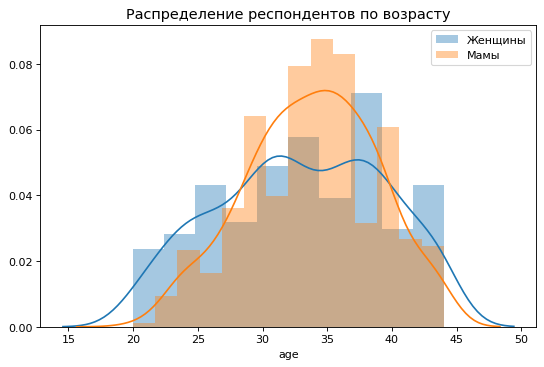

In [84]:
#график распределения респондентов по возрасту в разрезе категории "Женщины"/"Мамы"
plt.figure(figsize=(8,5), dpi= 80)
sns.distplot(df.loc[df['Cell'] == 1, 'age'], label="Женщины")
sns.distplot(df.loc[df['Cell'] == 2, 'age'], label="Мамы")
plt.title('Распределение респондентов по возрасту', fontsize=13)
plt.legend()
plt.show()

По распределению по возрасту видим, что наибольшее число респондентов категории "Мамы" находятся в возрастном диапазоне 29-40 лет (напомним, "Мамы" означает наличие детей от 3 до 12 лет). 

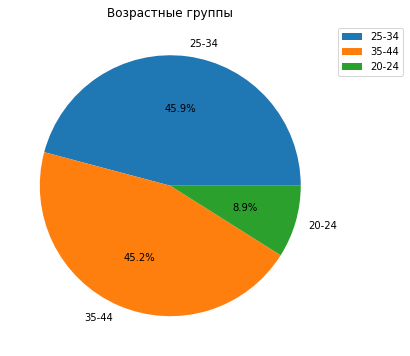

In [85]:
df.groupby('AgeRange')['AgeRange'].count().sort_values(ascending=False).plot(title='Возрастные группы', kind='pie', autopct='%1.1f%%', figsize=(6,6))
plt.ylabel('')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0));

Респонденты деляться на 3 возрастные группы неравномерно:

- возрастные категории "25-34" и "35-44" делят пользователей на относительно одинаковые группы, которые составляют 45,9% и 45,2% от общего числа респондентов соотвественно

- Респонденты возрастной группы "20-24" составляют лишь 8,9% опрашиваемых

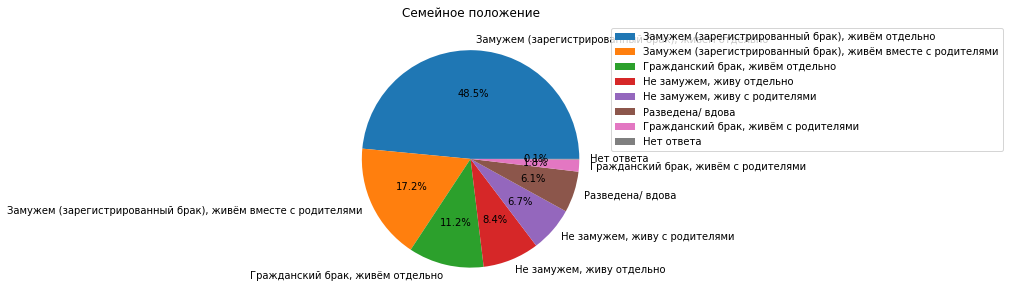

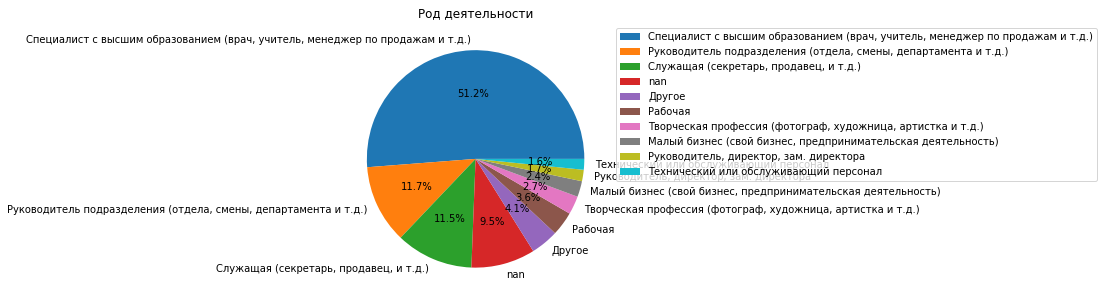

In [86]:
#построим диаграммы по характеристикам целевой аудитории
columns_bar = ['D3', 'D5']
dict_demography = {'D3':'Семейное положение',
                   'D5':'Род деятельности',
                   'D10':'Уровень дохода',
                  'D11':'Средний доход на 1 члена семьи'}

for col in columns_bar:
    df.groupby(col)[col].count().sort_values(ascending=False).plot(title=dict_demography[col], kind='pie', autopct='%1.1f%%', figsize=(5,5))
    plt.ylabel('')
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

**Распределение респондентов по статусу:**

- 78% опрошенных - замужем
- 50% - специалисты в разных направлениях с высшим образованием
- Около 15% - женщины-руководители, предприниматели
- 16,7% - профессии со средне-специальным образованием и неквалифицированный персонал
- Домохозяйки и безработные составили всего 8% в сумме. 

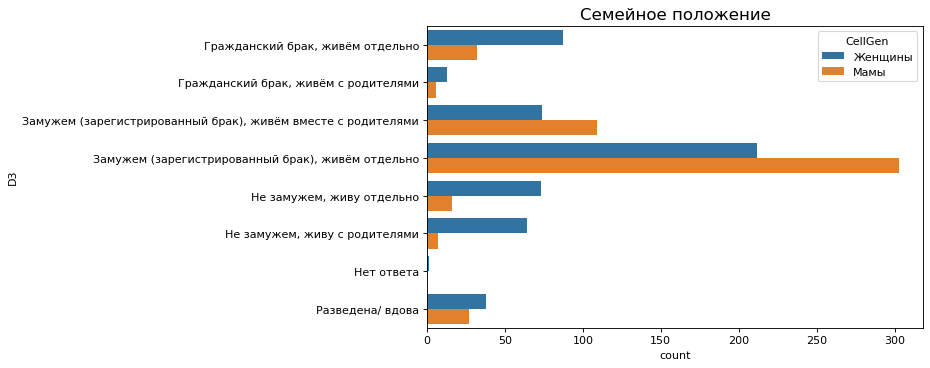

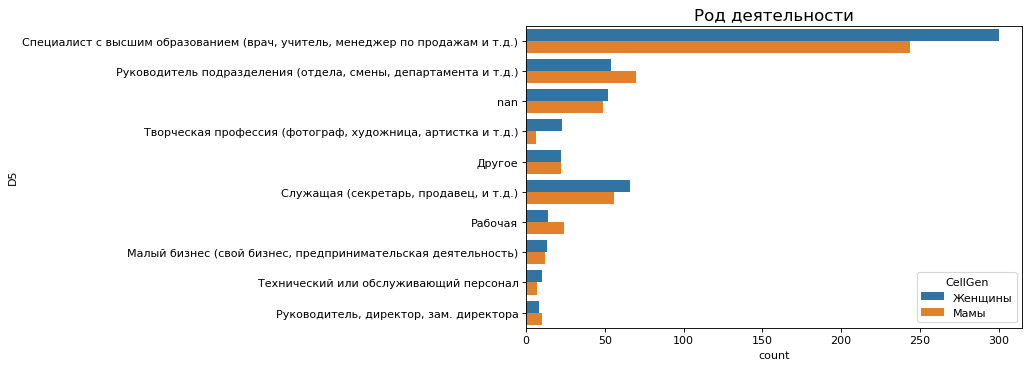

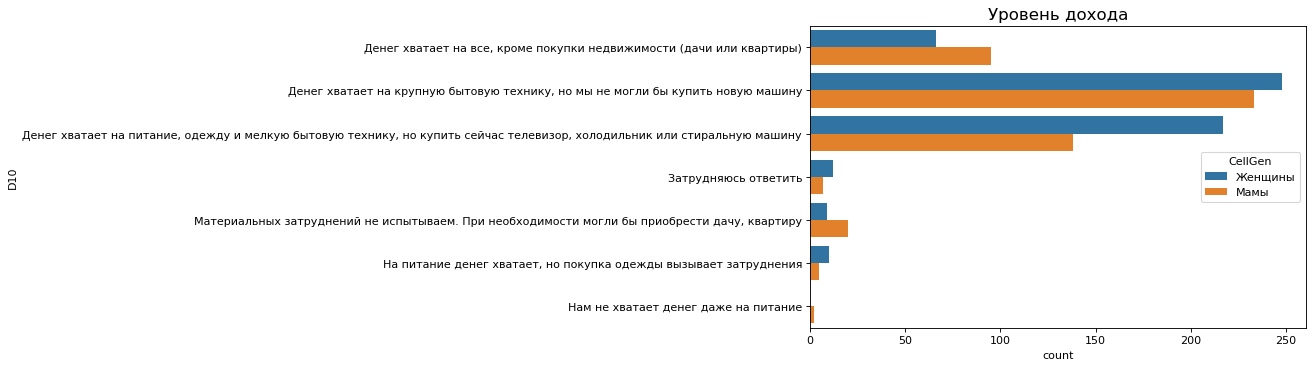

In [87]:
#построим диаграммы по характеристикам целевой аудитории в разрезе категорий "Женщины" и "Мамы"
columns_bar = ['D3', 'D5', 'D10']
dict_demography = {'D3':'Семейное положение',
                   'D5':'Род деятельности',
                   'D10':'Уровень дохода',
                  'D11':'Средний доход на 1 члена семьи'}

for col in columns_bar:
    plt.figure(figsize=(8,5), dpi= 80)
    sns.countplot(orient = "h", y=col, data=df, hue='CellGen')
    plt.title(dict_demography[col], fontsize=15)
    plt.show()

**На графиках распределения демографических признаков в разерезе категорий, наблюдаем различия между "Женщинами" и "Мамами" по некоторым признакам:**

- Пропорции семейного положения показывают, что среди семейных пар, живущих отдельно от родителей, в гражданском браке оказалось более чем в 2 раза больше "Женщин", чем "Мам", а вот "Замужем" - "Мам" на 1/3 больше, чем "Женщин".
- По роду деятельности "Женщины" опережают "мам" в узкоспециализированных профессиях с высшим образованием, творческих профессиях, служащих.
- Руководящие должности в представленной выборке больше занимают "Мамы"
- В категориях с самым высоким уровнем дохода в процентном соотношении также лидирут "Мамы" 

**Выбор пользователей в вопросах Дизайна DesignStyle**

Для исследования, какие паттерны предпочитает целевая аудитория, посмотрим на распределение выбранных наборов изображеий:

1. Категориальные данные в колонках DS (значения - название выбранных картинок на этапах анкетирования)

2. Числовые значения оценок дизайна (рейтинги картинок) в колонках rank (73 картинк - для "женщин" и 70 картинки для "мам").

Распределение выбора графических картинок. Посмотрим, какие картинки участницы опроса выбирали чаще всего на первом шаге. 

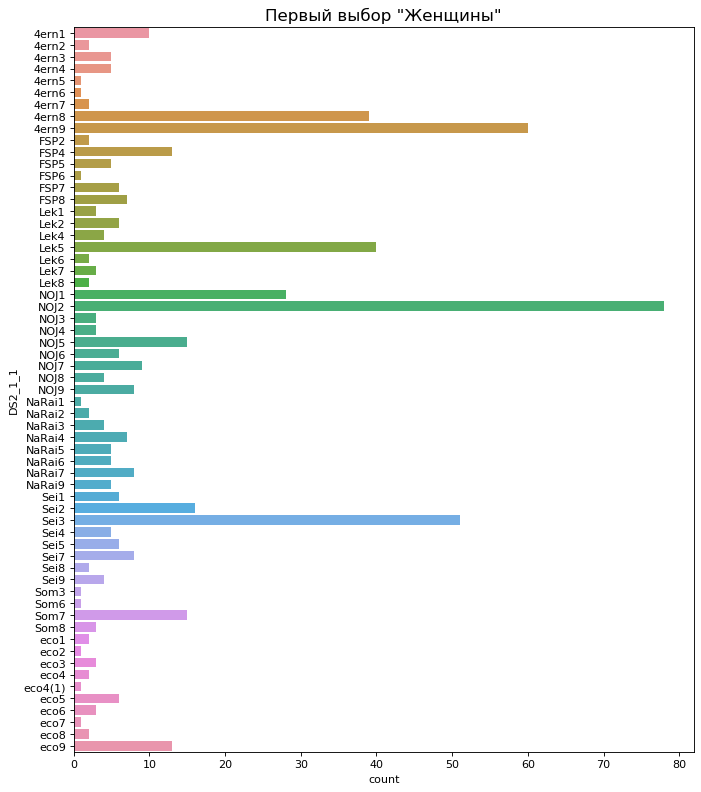

In [88]:
plt.figure(figsize=(10,12), dpi= 80)
sns.countplot(y='DS2_1_1', data=df)
plt.title('Первый выбор "Женщины"', fontsize=15)
plt.show()

"Лидеры" первого выбора "Женщин" картинки под кодовыми названиями: NOJ2, 4ern9, Sei3 и т.д. Какие образы "зашиты" в этих псевдонимах предстоит выяснить в дальнейшем исследовании.

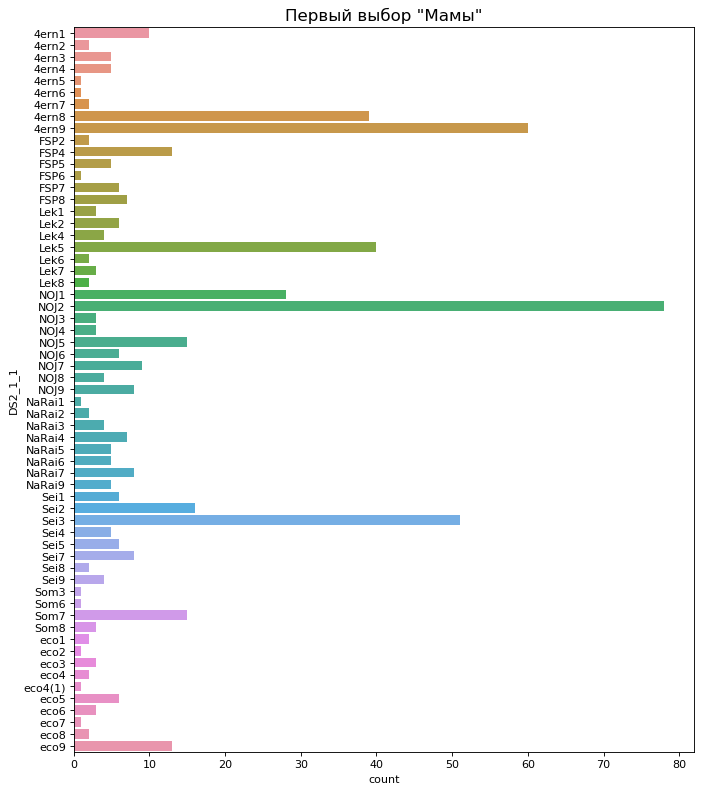

In [89]:
plt.figure(figsize=(10,12), dpi= 80)
sns.countplot(y='DS2_1_1', data=df)
plt.title('Первый выбор "Мамы"', fontsize=15)
plt.show()

Изучим числовые характеристики выборных изображений. Личный рейтинг картинок каждого пользователя находится в значениях колонок rank.

Количество ранговых картинок соотвествует числу набора изображений для каждой группы.

Соответсвие картинок рангу следующее (название картинки - колонка с рангом):

4ern1 - rank1_1

4ern2 - rank1_2

...... и т.д.

Последовательность и соотвествие для каждого набора представлено в файлах с тегами. 
В файлах с тегами наименование колонок соотвествует кодовому названию каждой картинки в последовательности, соотвествующей номерам оценочных ранговых значений в колонках "rank".

Наборы картинок описаны для каждой категории отдельно: для категории "женщины" набор состоит из 73 картинок, для категории "мамы" - 70 картинок.

**Исследование популярных графических паттернов для категории "Женщины"**

In [90]:
col_rank1 = columns_search('rank1')
col_rank1.append('CellGen')

#выборка числовых рангов картинок (категория "женщины") 
rank1 = df.query('CellGen == "Женщины"')[col_rank1]
rank1

,rank1_1,rank1_2,rank1_3,rank1_4,rank1_5,rank1_6,rank1_7,rank1_8,rank1_9,rank1_10,...,rank1_65,rank1_66,rank1_67,rank1_68,rank1_69,rank1_70,rank1_71,rank1_72,rank1_73,CellGen
0,1.613713,0.248339,0.248339,0.248339,0.729808,0.248339,0.248339,1.613713,0.933476,0.248339,...,0.248339,0.123773,0.123773,0.123773,0.248339,0.123773,0.248339,0.123773,0.123773,Женщины
2,0.981725,0.222780,0.222780,0.222780,0.126897,0.497223,0.222780,0.559199,0.470563,0.222780,...,0.126897,0.126897,0.222780,0.126897,0.981725,0.126897,0.981725,0.981725,0.222780,Женщины
3,0.211237,0.211237,0.211237,0.127850,0.127850,0.830773,0.211237,0.427311,0.339729,0.127850,...,0.211237,0.830773,0.830773,0.127850,0.127850,0.830773,0.388015,0.211237,0.211237,Женщины
4,0.981725,0.559199,0.981725,0.446296,0.981725,0.424127,0.981725,5.585418,8.236126,0.126897,...,0.222780,0.126897,0.222780,0.126897,0.126897,0.222780,0.222780,0.222780,0.222780,Женщины
6,0.117872,0.193437,0.902285,14.318620,0.117872,0.193437,0.193437,3.249283,36.499899,0.193437,...,0.193437,0.193437,0.193437,0.448826,4.156063,0.193437,0.193437,0.902285,0.902285,Женщины
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,0.252853,0.252853,0.252853,0.252853,0.252853,0.252853,0.252853,0.252853,0.118504,0.252853,...,0.252853,0.252853,0.252853,0.252853,0.252853,0.252853,0.252853,0.252853,0.252853,Женщины
1027,0.225670,0.225670,0.445084,0.557680,0.225670,0.225670,0.225670,0.225670,3.222195,1.078215,...,0.125270,0.225670,0.125270,0.225670,1.078215,0.225670,0.225670,0.225670,0.125270,Женщины
1029,0.232489,0.232489,0.121311,0.232489,0.232489,3.215762,0.121311,0.232489,0.933394,1.418757,...,0.232489,0.232489,0.232489,0.232489,0.232489,0.121311,1.418757,0.232489,4.113188,Женщины
1053,0.199478,0.199478,0.388324,0.831434,0.831434,0.199478,0.199478,0.407163,14.356237,0.831434,...,0.122898,3.257819,0.122898,0.122898,0.199478,0.199478,0.831434,0.122898,0.122898,Женщины


По предварительной информации знаем, что ранги картинок были рассчитаны таким образом, что сумма средних значений рангов по всем картинкам должна составить 100. Проверим соответствие данному условию.

In [91]:
#средние значения по каждой колонке
rank1.groupby('CellGen').mean()

,rank1_1,rank1_2,rank1_3,rank1_4,rank1_5,rank1_6,rank1_7,rank1_8,rank1_9,rank1_10,...,rank1_64,rank1_65,rank1_66,rank1_67,rank1_68,rank1_69,rank1_70,rank1_71,rank1_72,rank1_73
CellGen,,,,,,,,,,,,,,,,,,,,,
Женщины,1.544313,0.849429,1.509811,1.384166,0.83269,1.018547,0.840939,4.814336,6.671622,0.582957,...,1.094291,0.335884,0.35626,0.322387,0.216218,0.429479,0.445106,2.170379,0.604607,0.338794
Мамы,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
#трасформируем таблицу средних значений рангов
rank1_mean = rank1.groupby('CellGen').mean().reset_index().transpose()
rank1_mean = rank1_mean[1:].reset_index().dropna(axis = 1, thresh=1)
rank1_mean.columns = ['rank_name', 'mean']
rank1_mean

,rank_name,mean
0,rank1_1,1.54431
1,rank1_2,0.849429
2,rank1_3,1.50981
3,rank1_4,1.38417
4,rank1_5,0.83269
...,...,...
68,rank1_69,0.429479
69,rank1_70,0.445106
70,rank1_71,2.17038
71,rank1_72,0.604607


In [93]:
# сумма средних значений ранговых переменных rank_1 для группы "Женщины"
rank1_mean['mean'].sum()

100.00000000000001

In [94]:
#определим ТОП-7 картинок для категории "Женщины"
rank1top7 = rank1_mean.sort_values('mean', ascending=False).head(7)
rank1top7

,rank_name,mean
47,rank1_48,8.32491
8,rank1_9,6.67162
57,rank1_58,5.66959
7,rank1_8,4.81434
32,rank1_33,4.77955
46,rank1_47,4.01029
50,rank1_51,2.55538


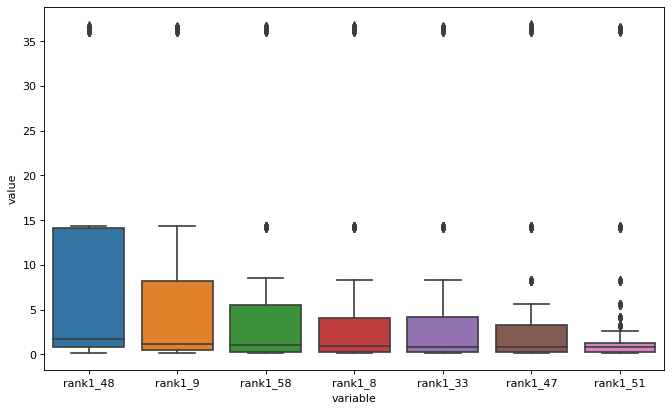

In [95]:
#график распределения рангов топовых картинок в формате boxplot
plt.figure(figsize=(10,6), dpi= 80)
sns.boxplot(x="variable", y="value", data=pd.melt(df[list(rank1top7['rank_name'])]));

На графике представлены распределения топовых картинок, с наибольшим средним рангом (оценкой) в категории "Женщины". Открывает топ картинка под кодовым оценочным лэйблом rank1_48. Выше мы получили ТОП первого выбора категории "Женщины" с кодовыми названиями образов. Под номером 1 - картинка "NOJ2".

Предполагаем, что максимальный оценочный ранг установлен у топовой картинки. Проверим, что оценочные ранги соотвествуют картинкам в файле с описанием тегов по поряковому номеру колонки с картинкой, то есть 'rank1_48' соотвествует картинке под названием 'NOJ2':

In [96]:
# проверим 48й столбец датасета с описанием картинок для категории "Женщины"
women_tags.iloc[:, [47]]

,NOJ2
,
тренд,NaN
описание,новая жен
силуэт,NaN
оверсайз,NaN
приталенный силуэт,V
...,...
цветы,NaN
шляпа/шапка,NaN
сумка,NaN


Предположение о соотвествии рангов последовательности кодовых картинок в файле с описанием тегов подтвердилось.

In [97]:
# обзор числовых описаний ранга топовых картинок
df[list(rank1top7['rank_name'])].describe()

,rank1_48,rank1_9,rank1_58,rank1_8,rank1_33,rank1_47,rank1_51
count,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000
mean,8.324911,6.671622,5.669593,4.814336,4.779551,4.010293,2.555379
std,12.075958,10.975808,10.309180,9.320730,9.453491,8.178749,6.272795
min,0.114912,0.115918,0.115198,0.117000,0.115521,0.116108,0.115918
25%,0.798983,0.524662,0.261501,0.257190,0.226642,0.259105,0.236119
50%,1.683366,1.143270,1.029750,0.917105,0.830773,0.860861,0.830773
75%,14.142100,8.184752,5.557654,4.115851,4.128724,3.237172,1.259649
max,36.826941,36.712196,36.653237,36.772300,36.648990,36.930585,36.566682


Определив топовые картинки, обратимся к их описанию, узнаем, какие паттерны "вшиты" в картинки, наиболее популярные среди опрашиваемых. Теги, которые пересекаются у топовых картинок и есть популярные тренды!

In [98]:
#просмотрим таблицу с тегами для категории "Женщины" (датафрейм был загружен на первом шаге)
women_tags.head()

,eco1,eco2,eco3,eco4,eco4 (графитовый плащ),eco5,eco6,eco7,eco8,eco9,...,NaRai9,lek1,lek2,lek3,lek4,lek5,lek6,lek7,lek8,lek9
,,,,,,,,,,,,,,,,,,,,,
тренд,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
описание,Экология,экология,экология,экология,экология,экология,экология,экология,экология,экология,...,на районе,лекторий,лекторий,лекторий,лекторий,лекторий,лекторий,лекторий,лекторий,лекторий
силуэт,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
оверсайз,V,V,V,V,V,NaN,V,V,V,NaN,...,V,NaN,NaN,V,NaN,NaN,NaN,NaN,V,NaN
приталенный силуэт,V,NaN,NaN,NaN,NaN,V,NaN,NaN,NaN,V,...,NaN,NaN,NaN,NaN,V,V,NaN,V,NaN,NaN


In [99]:
woman_trends = women_tags.transpose().reset_index()
woman_trends.head()

,index,тренд,описание,силуэт,оверсайз,приталенный силуэт,удлиненный,укороченный,многослойность,один слой,...,нейтральный фон,интерьер статусный,интерьер развалюха,NaN,реквизит,цветы,шляпа/шапка,сумка,очки,шарф
0,eco1,NaN,Экология,NaN,V,V,V,NaN,NaN,V,...,V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,eco2,NaN,экология,NaN,V,NaN,V,NaN,NaN,V,...,V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,eco3,NaN,экология,NaN,V,NaN,V,NaN,NaN,V,...,V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V
3,eco4,NaN,экология,NaN,V,NaN,V,NaN,V,NaN,...,V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V
4,eco4 (графитовый плащ),NaN,экология,NaN,V,NaN,NaN,NaN,V,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V


In [100]:
#соединим с таблицей средних оценок по картинкам по индексу (соотвествие очередности картинок значению: rank1-rank73)
trends1 = rank1_mean.merge(woman_trends, left_index=True, right_index=True, how='outer')

In [101]:
#топ7 по среднему значению rank
top7_trends = trends1.sort_values('mean', ascending=False).head(7)

#удалим колонки, в которых пропущены все значения (из-за пустых с строк в исходном файле)
top7_trends = top7_trends.dropna(axis = 1, thresh=1)
top7_trends

,rank_name,mean,index,описание,оверсайз,приталенный силуэт,удлиненный,многослойность,один слой,регуляр,...,не смотрит в кадр,вызов,уверенность,мягкость,одна модель,медитативная,студия,нейтральный фон,цветы,шарф
47,rank1_48,8.32491,NOJ2,новая жен,NaN,V,NaN,NaN,V,V,...,NaN,NaN,NaN,V,V,NaN,NaN,V,NaN,NaN
8,rank1_9,6.67162,eco8,экология,V,NaN,V,NaN,V,NaN,...,NaN,NaN,NaN,NaN,V,NaN,NaN,V,NaN,NaN
57,rank1_58,5.66959,NaRai3,на районе,NaN,NaN,NaN,V,NaN,V,...,NaN,V,V,NaN,V,NaN,NaN,V,NaN,V
7,rank1_8,4.81434,eco7,экология,V,NaN,V,NaN,V,NaN,...,NaN,NaN,NaN,NaN,V,NaN,NaN,V,V,NaN
32,rank1_33,4.77955,som5,сомнительная схема,V,NaN,V,V,NaN,NaN,...,NaN,NaN,V,NaN,V,NaN,V,NaN,NaN,NaN
46,rank1_47,4.01029,NOJ1,новая жен,V,NaN,V,V,NaN,NaN,...,V,NaN,NaN,V,V,NaN,V,NaN,V,NaN
50,rank1_51,2.55538,NOJ5,новая жен,NaN,NaN,V,V,NaN,V,...,V,NaN,NaN,V,V,V,NaN,NaN,NaN,NaN


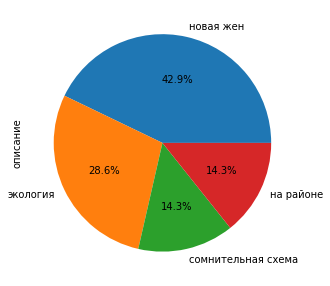

In [102]:
top7_trends['описание'].value_counts().plot(kind='pie', figsize=(5,5), autopct='%1.1f%%');

Каждая картинка относена к одному из трендов, а также описывается набором тегов. К одному и тому же тренду могут относится несколько картинок, а вот теги у них могут отличаться.

На круговой диаграмме мы видим, какие тренды несут в себе картики ТОП-7 категории "Женщины":

- 42,9% - "новая жен"
- 28,6% - "экология"
- по 14,3 - "на районе", "сомнительная схема"

К сожалению, в нашем распоряжении нет исходных картинок или развернутого описания трендов по названиям "новая жен" и др. Эта информация в распоряжении составителей анкеты. Но мы можем в рамках исследования изучить описательные теги у топовых картинок, по которым составим трендовые образы.

In [103]:
#теги
top7_trends.iloc[:,3:].groupby('описание').count().sum().sort_values(ascending=False)

одна модель                 7
несексуализированный        7
расслабленное               6
европейка                   5
удлиненный                  5
осень-зима                  5
весна-лето                  5
спокойная гамма             5
 светлая                    4
многослойность              4
брюки                       4
брюнетка                    4
оверсайз                    4
нейтральный фон             4
кадр без лица (со спины)    3
один слой                   3
романтик                    3
регуляр                     3
задумчивое                  3
мягкость                    3
студия                      2
не смотрит в кадр           2
свитер                      2
цветы                       2
бомбер/ветровка             2
уверенность                 2
блузка                      2
смотрит в кардр             2
платье                      2
медитативная                1
приталенный силуэт          1
собранное                   1
пальто/плащ                 1
треники   

**Популряные паттерны в категории "Женщины":**

- одна модель                 
- несексуализированный        
- расслабленное               
- европейка                   
- осень-зима                  
- весна-лето                  
- спокойная гамма             
- удлиненный                  
- брюки                       
- брюнетка                    
- оверсайз                    
- нейтральный фон             
- многослойность              
-  светлая                    

**Исследование популярных графических паттернов для категории "Мамы"**

По аналогии разберем популярные паттерны для категории "Мамы". Выводить промежуточные таблицы не будем, так как последовательность действий точно такая же, как для категории "Женщины".

In [104]:
#просмотрим таблицу с тегами для категории "Женщины" (датафрейм был загружен на первом шаге)
children_tags.head()

,4ern1,4ern2,4ern3,4ern4,4ern6,4ern7,uni1,uni2,uni3,uni4,...,jun5,jun6,jun7,bar1,bar2,bar3,bar4,bar5,bar6,bar7
,,,,,,,,,,,,,,,,,,,,,
тренд,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
описание,дарк-фешн,дарк-фешн,дарк-фешн,дарк-фешн,дарк-фешн,дарк-фешн,универсальность,универсальность,универсальность,универсальность,...,джунгли,джунгли,джунгли,лекторий,лекторий,лекторий,лекторий,лекторий,лекторий,лекторий
пол,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
девочка,V,NaN,NaN,NaN,V,NaN,V,V,NaN,NaN,...,V,V,V,V,NaN,V,NaN,V,V,V
мальчик,NaN,V,V,V,NaN,V,NaN,NaN,V,V,...,NaN,NaN,NaN,NaN,V,NaN,V,NaN,NaN,NaN


In [105]:
col_rank2 = columns_search('rank2')
col_rank2.append('CellGen')

#выборка числовых рангов картинок (категория "Мамы") 
rank2 = df.query('CellGen == "Мамы"')[col_rank2]

In [106]:
#средние значения по каждой колонке
rank2.groupby('CellGen').mean()

,rank2_1,rank2_2,rank2_3,rank2_4,rank2_5,rank2_6,rank2_7,rank2_8,rank2_9,rank2_10,...,rank2_61,rank2_62,rank2_63,rank2_64,rank2_65,rank2_66,rank2_67,rank2_68,rank2_69,rank2_70
CellGen,,,,,,,,,,,,,,,,,,,,,
Женщины,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Мамы,0.664011,0.79806,1.531034,0.7083,0.616754,2.610428,1.382122,2.150647,2.227736,1.925685,...,2.049794,1.289162,0.481966,0.478541,2.053679,1.49266,2.550159,0.760537,2.233888,1.959804


In [107]:
#трасформируем таблицу средних значений рангов
rank2_mean = rank2.groupby('CellGen').mean().reset_index().transpose()
rank2_mean = rank2_mean[1:].reset_index().dropna(axis = 1, thresh=1)
rank2_mean.columns = ['rank_name', 'mean']
rank2_mean

,rank_name,mean
0,rank2_1,0.664011
1,rank2_2,0.79806
2,rank2_3,1.53103
3,rank2_4,0.7083
4,rank2_5,0.616754
...,...,...
65,rank2_66,1.49266
66,rank2_67,2.55016
67,rank2_68,0.760537
68,rank2_69,2.23389


In [108]:
#определим ТОП-7 картинок для категории "Мамы"
rank2top7 = rank2_mean.sort_values('mean', ascending=False).head(7)
rank2top7

,rank_name,mean
35,rank2_36,4.2362
16,rank2_17,3.37446
41,rank2_42,3.37423
10,rank2_11,3.2856
13,rank2_14,3.14748
11,rank2_12,2.83626
12,rank2_13,2.75005


In [109]:
#числовое описание распределений оценочных рангов картинок для категории "Мамы"
df[list(rank2top7['rank_name'])].describe()

,rank2_36,rank2_17,rank2_42,rank2_11,rank2_14,rank2_12,rank2_13
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,4.236196,3.374458,3.374232,3.285598,3.147476,2.836262,2.750054
std,8.932760,7.455375,8.356296,8.233748,7.311140,7.303767,6.808396
min,0.123267,0.121909,0.121938,0.121909,0.121938,0.125438,0.124608
25%,0.233688,0.232568,0.221647,0.221647,0.236229,0.230340,0.222699
50%,0.833143,0.833208,0.428601,0.426793,0.833143,0.526519,0.833143
75%,2.653240,1.732300,1.032139,1.285024,1.420611,1.030365,1.196754
max,36.746277,36.953434,36.728577,36.746277,36.746277,36.728577,36.746277


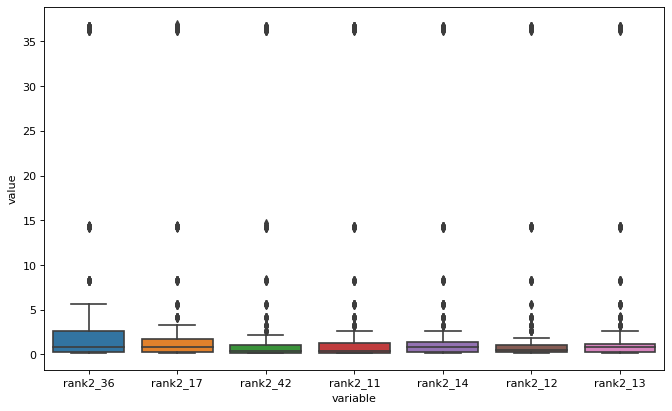

In [110]:
#распределение оценок по топовым картинкам в категории "Дети" boxplot
plt.figure(figsize=(10,6), dpi= 80)
sns.boxplot(x="variable", y="value", data=pd.melt(df[list(rank2top7['rank_name'])]))

Распределение рангов топовых картинок в категории "Мамы" более равномерно, чем у "Женщин". Результаты предсказуемы, размах значений небольшой, разрыв между 2м-7м местами незначительный. 

In [111]:
# обзор числовых описаний ранга топовых картинок
df[list(rank2top7['rank_name'])].describe()

,rank2_36,rank2_17,rank2_42,rank2_11,rank2_14,rank2_12,rank2_13
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,4.236196,3.374458,3.374232,3.285598,3.147476,2.836262,2.750054
std,8.932760,7.455375,8.356296,8.233748,7.311140,7.303767,6.808396
min,0.123267,0.121909,0.121938,0.121909,0.121938,0.125438,0.124608
25%,0.233688,0.232568,0.221647,0.221647,0.236229,0.230340,0.222699
50%,0.833143,0.833208,0.428601,0.426793,0.833143,0.526519,0.833143
75%,2.653240,1.732300,1.032139,1.285024,1.420611,1.030365,1.196754
max,36.746277,36.953434,36.728577,36.746277,36.746277,36.728577,36.746277


В таблице числового описания распределения рангов видим, что диапазон большинства значений ТОПовой картинки лежит в диапазоне 0,2 - 2,6, при этом максимальные значения достигают 36!

Значения рангов картинок со 2й по 7ю в ТОП-листе в среднем лежат в пределах 0,2 - 1,7, максимальные выбросы одинаковые у всех топовых картинок - около 36.

Это говорит о том, что каждую из этих картинок определенная доля пользователей выбирала первой, за счет чего был определен максимальный оценочный ранг.

In [112]:
#просмотрим таблицу с тегами для категории "Женщины" (датафрейм был загружен на первом шаге)
children_tags.head()

,4ern1,4ern2,4ern3,4ern4,4ern6,4ern7,uni1,uni2,uni3,uni4,...,jun5,jun6,jun7,bar1,bar2,bar3,bar4,bar5,bar6,bar7
,,,,,,,,,,,,,,,,,,,,,
тренд,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
описание,дарк-фешн,дарк-фешн,дарк-фешн,дарк-фешн,дарк-фешн,дарк-фешн,универсальность,универсальность,универсальность,универсальность,...,джунгли,джунгли,джунгли,лекторий,лекторий,лекторий,лекторий,лекторий,лекторий,лекторий
пол,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
девочка,V,NaN,NaN,NaN,V,NaN,V,V,NaN,NaN,...,V,V,V,V,NaN,V,NaN,V,V,V
мальчик,NaN,V,V,V,NaN,V,NaN,NaN,V,V,...,NaN,NaN,NaN,NaN,V,NaN,V,NaN,NaN,NaN


In [113]:
children_trends = children_tags.transpose().reset_index()
children_trends.head()

,index,тренд,описание,пол,девочка,мальчик,силуэт,оверсайз,приталенный силуэт,удлиненный,...,интерьер,спортивная локация,NaN,реквизит,музыкальный инструмент,шапка/шляпа,шарф,очки,сумка/рюкзак,велик
0,4ern1,NaN,дарк-фешн,NaN,V,NaN,NaN,NaN,NaN,V,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4ern2,NaN,дарк-фешн,NaN,NaN,V,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4ern3,NaN,дарк-фешн,NaN,NaN,V,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4ern4,NaN,дарк-фешн,NaN,NaN,V,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4ern6,NaN,дарк-фешн,NaN,V,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [114]:
#соединим с таблицей средних оценок по картинкам по индексу (соотвествие очередности картинок значению: rank2-rank70)
trends2 = rank2_mean.merge(children_trends, left_index=True, right_index=True, how='outer')
trends2 = trends2.replace(r'\s+','',regex=True)

In [115]:
#топ7 по среднему значению rank "Мамы"
top7_trends_kids = trends2.sort_values('mean', ascending=False).head(7)

#удалим колонки, в которых пропущены все значения (из-за пустых с строк в исходном файле)
top7_trends_kids = top7_trends_kids.dropna(axis = 1, thresh=1)
top7_trends_kids

,rank_name,mean,index,описание,девочка,мальчик,удлиненный,один слой,регулар,расслабленное,...,со спины,радость,безразличие,одна модель,две модели,природа,студия (нейтральный фон),шапка/шляпа,очки,сумка/рюкзак
35,rank2_36,4.236196,ret2,ретро,V,NaN,NaN,V,V,V,...,V,NaN,NaN,NaN,V,V,NaN,NaN,NaN,NaN
16,rank2_17,3.374458,tun4,тундра,NaN,V,NaN,NaN,V,V,...,V,NaN,NaN,V,NaN,V,NaN,V,NaN,NaN
41,rank2_42,3.374232,ret7,ретро,V,NaN,NaN,V,V,V,...,NaN,NaN,V,V,NaN,NaN,V,V,NaN,NaN
10,rank2_11,3.285598,uni5,универсальность,NaN,V,NaN,V,V,V,...,NaN,V,NaN,V,NaN,NaN,V,NaN,NaN,NaN
13,rank2_14,3.147476,tun1,тундра,V,NaN,V,NaN,V,V,...,NaN,NaN,V,V,NaN,V,NaN,NaN,V,V
11,rank2_12,2.836262,uni6,универсальность,V,V,NaN,V,V,V,...,NaN,V,NaN,NaN,V,NaN,V,V,NaN,NaN
12,rank2_13,2.750054,uni7,универсальность,V,NaN,NaN,V,V,V,...,NaN,V,NaN,V,NaN,NaN,V,NaN,NaN,NaN


Соединили таблицу с рангами и описанием кодовых образов. Основываясь на числовом показателе рангов, выбрали ТОП-7 картинок и теперь можем выявить общие тренды ТОПовых картинок:

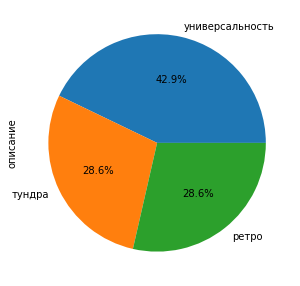

In [116]:
top7_trends_kids['описание'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(5,5));

**Выявили ведущие тренды в категории "Мамы":**

- 42,9% - "универсальность"
- по 28,6% - "тундра" и "ретро"

In [117]:
# популярные теги в категории "Мамы"
top7_trends_kids.iloc[:,3:].groupby('описание').count().sum().sort_values(ascending=False)

расслабленное                7
регулар                      7
весна-лето                   6
девочка                      5
одна модель                  5
спокойная гамма              5
один слой                    5
осень-зима                   4
европейка                    4
брюнетка                     4
тотал лук                    4
природный полноцвет          4
студия (нейтральный фон)     4
отсутствие принта            3
радость                      3
треники                      3
шапка/шляпа                  3
природа                      3
толстовка/свитшот            3
фигуративный принт           3
мальчик                      3
смотрит в кардр              3
две модели                   2
яркий акцент                 2
бомбер/куртка                2
блондинка                    2
не смотрит в кадр            2
со спины                     2
романтик                     2
задумчивое                   2
футболка/топ                 2
безразличие                  2
удлиненн

**Тренды в категории "Мамы":**
    
- расслабленное                
- регулар                      
- весна-лето                   
- девочка                      
- одна модель                  
- спокойная гамма              
- один слой                    
- осень-зима                   
- европейка                    
- брюнетка                     
- тотал лук                    
- природный полноцвет          
- студия (нейтральный фон)     

**Вывод:** По графикам видим, что выбросы есть у всех топовых картинок. Это связано с различиями восприятия разными людьми графической информации и мировосприятия в целом. То, что нравится одним, другие воспринимают прохладнее.

Особенно это заметно по распределению оценок топовых картинок для категории "Мамы", так как ответы на вопросы в разной степени дает ребенок или мама.

Важно определить целевую аудиторию, выделить базовые группы, влияние различных факторов на восприятие окружающего мира.

Каждая из картинок, показанная пользователям, относится к определенной категории. По выбранным ТОП-7 картинок определили, к каким категориям относятся самые популярные картинки по версии респондентов.

**Кодовые категории ТОП изображений для группы "Женщины":**
- новая жен
- экология  
- на районе  
- сомнительная схема

**Кодовые категории ТОП изображений для группы "Мамы":**
- универсальность
- тундра
- ретро  

**Ценностные характеристики LifeStyle**

In [118]:
#найдем все колонки по LS
columns_search('LS')

['LS1_1V',
 'LS1_2V',
 'LS1_5R',
 'LS1_6R',
 'LS1_9B',
 'LS1_10B',
 'LS1_11B',
 'LS1_14O',
 'LS1_15O',
 'LS1_16O',
 'LS1_20G',
 'LS1_21G',
 'LS1_22G',
 'LS1_26Y',
 'LS1_27Y',
 'LS1_28Y',
 'LS1_32',
 'LS1_33',
 'LS1_34',
 'LS2_3V',
 'LS2_4V',
 'LS2_7R',
 'LS2_8R',
 'LS2_12B',
 'LS2_13B',
 'LS2_17O',
 'LS2_18O',
 'LS2_19O',
 'LS2_23G',
 'LS2_24G',
 'LS2_25G',
 'LS2_29Y',
 'LS2_30Y',
 'LS2_31Y',
 'LS2_35',
 'LS2_36',
 'LS2_37',
 'LS2_38']

В анкете представлено 38 вопросов в категории жизненные ценности, разбитые на 2 части. Результаты анкетирования по Lifestyle располагаются в группах колонок LS1 и LS2.

In [119]:
df[columns_search('LS')].head()

,LS1_1V,LS1_2V,LS1_5R,LS1_6R,LS1_9B,LS1_10B,LS1_11B,LS1_14O,LS1_15O,LS1_16O,...,LS2_23G,LS2_24G,LS2_25G,LS2_29Y,LS2_30Y,LS2_31Y,LS2_35,LS2_36,LS2_37,LS2_38
0,4,3,3,4,4,3,5,3,5,5,...,4,3,5,4,5,3,5,2,3,3
1,4,3,4,3,4,4,4,4,4,4,...,3,4,5,4,5,3,5,5,3,4
2,5,3,3,4,5,5,5,3,5,5,...,3,4,5,5,4,2,3,1,3,2
3,4,3,5,3,4,3,5,4,4,5,...,3,3,4,4,5,4,4,3,3,4
4,3,3,4,4,5,2,3,4,5,4,...,3,3,4,5,5,4,3,3,3,4


In [120]:
#список колонок LS
list_columns = columns_search('LS')

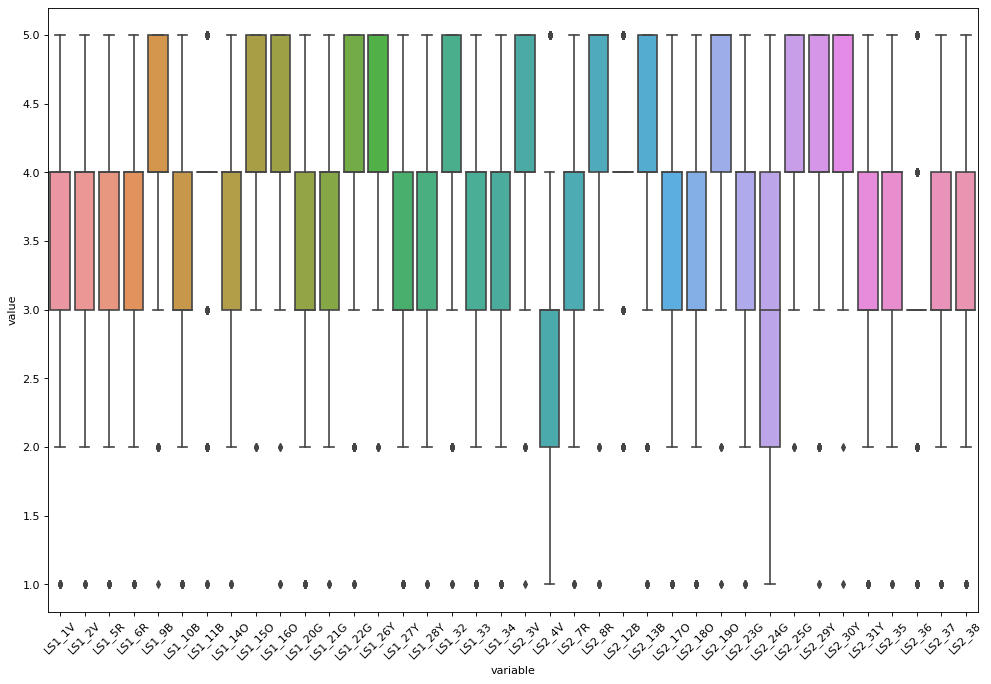

In [121]:
plt.figure(figsize=(15,10), dpi= 80)
sns.boxplot(x="variable", y="value", data=pd.melt(df[list(list_columns)]))
plt.xticks(rotation=45)
plt.show()

Распределения 13 из 38 вопросов выделяются сдвигом в сторону крайних положительных ответов "Согласия".

Наоборот выраженный отрицательный отклик получили 2 выражения "LS2_4V" и "LS2_24G". Оба выражения касаются проведения отпуска: перввое - об отпуске недалеко от дома, второе - в походе. 

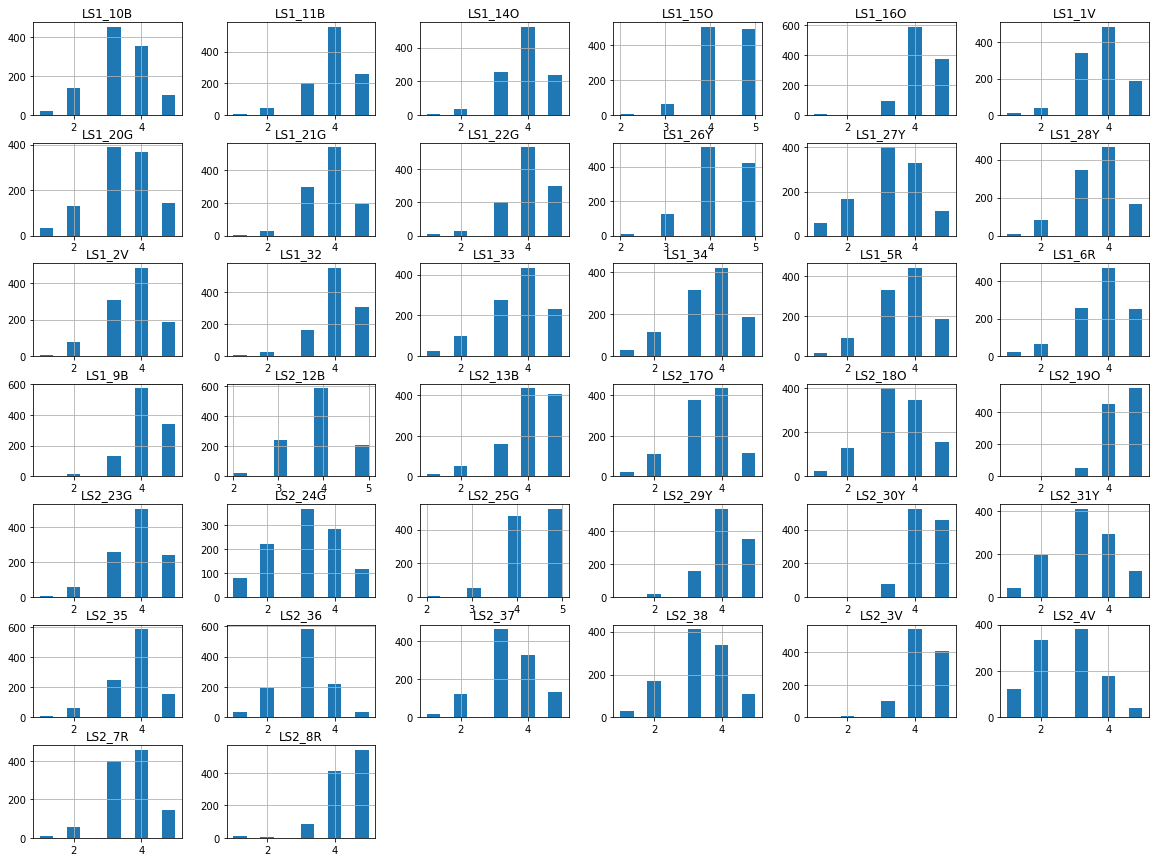

In [122]:
# распределение оценок Lifestyle
df[list(list_columns)].hist(figsize=(20,15));

**Выводы:**

По распределениям видим, что на большинство вопросов о жизненных ценностях респонденты отвечали "Отчасти согласен, отчасти нет" и "Скорее согласен". В большинстве случаев ядро ответов лежит в соседних парных значениях ответов (3-4, 4-5).

Самый большой отклик получили выражения:

- "Я хочу наслаждаться жизнью по-настоящему и хорошо проводить время".
- "В первую очередь меня волнует мое благополучение и благополучие моей семьи"

Большинство респондентов поддержали высказывания максимальными баллами 4-5, а "Совершенно несогласных" с первым выражением не нашлось ни одного среди анкетируемых респондентов.

**Взаимное распределение LS и DS**

Посмотрим на взаимное распределение некоторых признаков DesignStyle и LifeStyle

DS2_1_1 - Картинка "Первый выбор"

LS1_10B - Утверждение "В человеке для меня важна скромность"

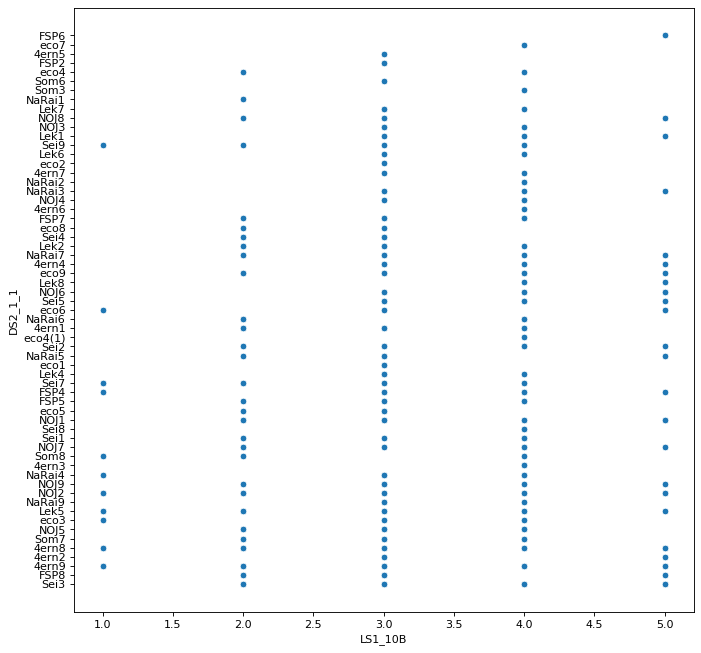

In [123]:
plt.figure(figsize=(10,10), dpi= 80)
sns.scatterplot(df['LS1_10B'], df['DS2_1_1']);

По графику взаимного распределения видим, что, например, пользователи, которые в первом выборе указали картинку "Lek8", крайне положительно отнеслись к выражению о важности скромности в человеке. То есть выбор визуального контента коррелирует с жизненными ценностями. 

**Построим матрицу корреляций по срезу признаков LS1 и ТОП-7 картинок по рейтингу DS**

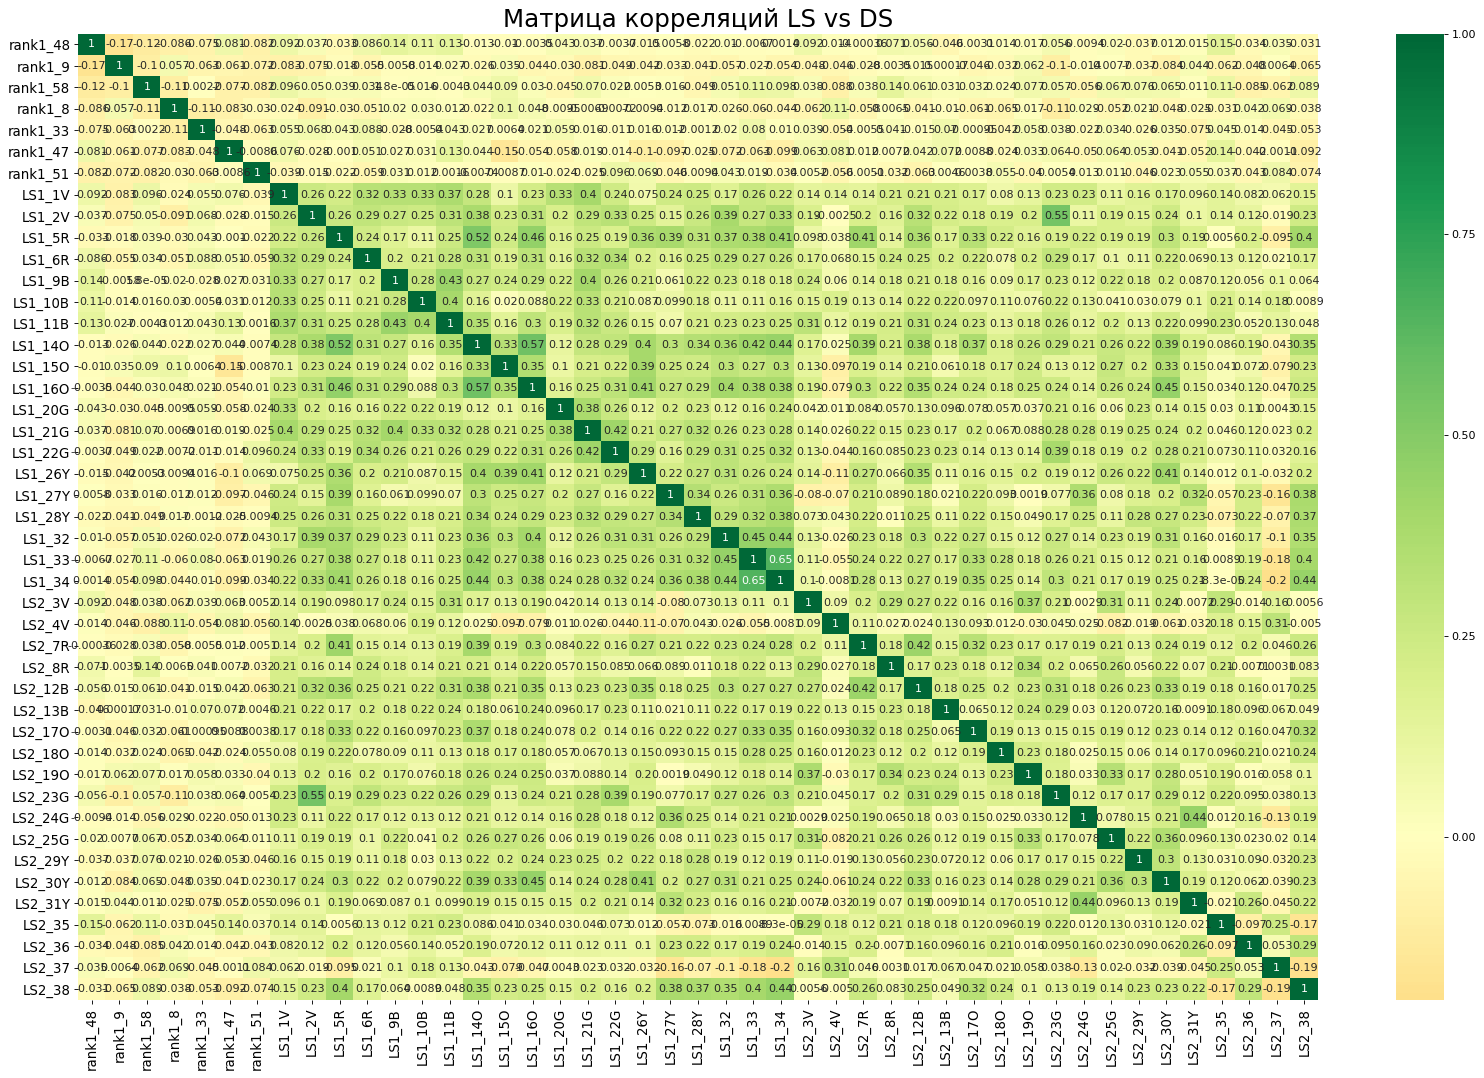

In [124]:
mergedlist = list(rank1top7['rank_name']) + list(list_columns)
data = df[mergedlist]

plt.figure(figsize=(25,16), dpi= 80)
sns.heatmap(data.corr(), xticklabels=data.corr().columns, yticklabels=data.corr().columns, cmap='RdYlGn', center=0, annot=True)

plt.title('Матрица корреляций LS vs DS', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

По тепловой карте увидели значительную корреляцию по некоторым вопросам LS между собой

Корреляция > 0.5 у пар выражений:

- LS2_33 "Я люблю покупать модные марки / вещи" / LS2_34 "Я люблю модные современные места"

- LS2_23G "Я предпочитаю вести здоровый образ жизни" / LS1_2V "Я внимательно слежу за своим здоровьем, потому что боюсь заболеть"

- LS1_14O "Продвижение вперед в жизни важно для меня. Я стараюсь все делать лучше, чем другие" / LS1_5R "Я хочу всегда быть тем, кто принимает решения. Мне нравится быть лидером."

С рейтингом топовой картинки DS1 коррелируют следующие выражения (корреляция 0.13 - 0.15):

- "Я стараюсь быть максимально вежливой со всеми"
- "В человеке для меня важна скромность"
- "Мне важно вести себя должным образом"
- "Я считаю, что мужчина должен быть способен обеспечить и защитить"
- "В целом у меня традиционный вкус в одежде"

## Кластерный анализ по вопросам LS<a id="clustering"></a>

In [125]:
#выборка колонок LS
X = df[columns_search('LS')]

#стандартизируем данные
scaler = StandardScaler() 
X_sc = scaler.fit_transform(X)

### Выбор оптимального числа кластеров <a id="cluster_number"></a>

Для разбиения пользователей на кластеры, основываясь на переменные с результатами опроса о жизненных ценностях, будем использовать метод К-средних. Этот метод требует указания предопределенного числа кластеров.

Для выявления оптимального числа кластеров, проведем дополнительное исследование:

- Построим дендрограмму методом иерархической кластеризации для визуального определения числа кластеров (с вариациями параметра метода)
- Попробуем определить чсило кластеров для К-средних методом "Локтя"
- Посчитаем коэффициенты критерия "Силуэт"

**Иерархическая кластеризация для определения оптимального числа кластеров**

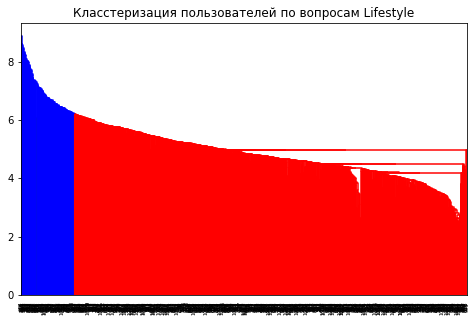

In [126]:
#задаем матрицу расстояний параметрами по умолчанию (по умолчанию установлен метод "single")
linked = linkage(X_sc)

#строим дендрограмму
plt.figure(figsize=(8, 5))  
dend = dendrogram(linked, orientation='top')
plt.title('Класстеризация пользователей по вопросам Lifestyle')
plt.show()

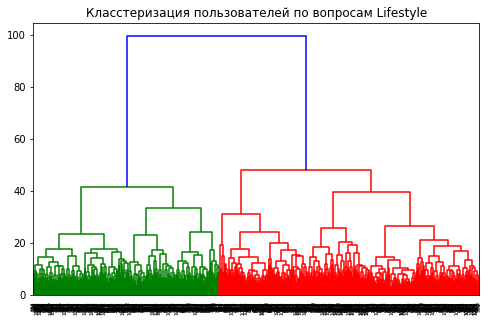

In [127]:
#задаем матрицу расстояний методом "ward"
linked = linkage(X_sc, method = 'ward', metric='euclidean')

#строим дендрограмму

plt.figure(figsize=(8, 5))  
dend = dendrogram(linked, orientation='top')
plt.title('Класстеризация пользователей по вопросам Lifestyle')
plt.show()

На дендрограммах, построенных методами "single" и "ward" визуально выделяются 2 кластера

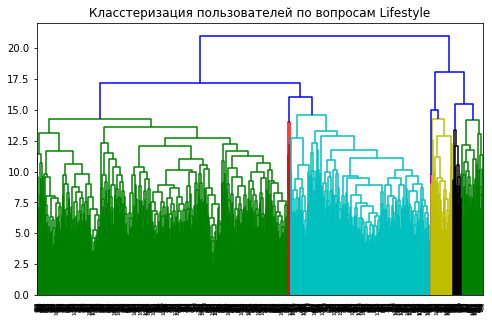

In [128]:
#задаем матрицу расстояний методом "complete"
linked = linkage(X_sc, method = 'complete')

#строим дендрограмму

plt.figure(figsize=(8, 5))  
dendrogram(linked, orientation='top')
plt.title('Класстеризация пользователей по вопросам Lifestyle')
plt.show()

Методом "complete" выделено 7 кластеров. Попробуем провести разбиение датасета данным методом на 7 кластеров и оценить размер полученных групп.

In [129]:
df['cluster'] = fcluster(linked, 7, criterion='maxclust')
df['cluster'].value_counts()

1    597
3    333
7     52
5     52
6     19
2      7
4      2
Name: cluster, dtype: int64

Присутсвют группы со слишком малой размерностью

**"Метод Локтя" для определения оптимального числа кластеров**

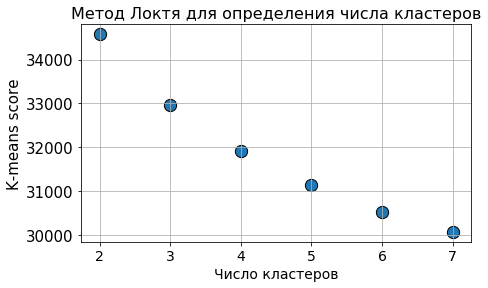

In [130]:
km_scores= []
km_silhouette = []

for i in range(2,8):
    km = KMeans(n_clusters=i, random_state=0).fit(X_sc)
    preds = km.predict(X_sc)    
    km_scores.append(-km.score(X_sc))
    silhouette = silhouette_score(X_sc,preds)
    km_silhouette.append(silhouette)
    
plt.figure(figsize=(7,4))
plt.title("Метод Локтя для определения числа кластеров",fontsize=16)
plt.scatter(x=[i for i in range(2,8)],y=km_scores,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Число кластеров",fontsize=14)
plt.ylabel("K-means score",fontsize=15)
plt.xticks([i for i in range(2,8)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

На графике визуально не определяется "Локоть", этот метод на нашей выборке оказался неинформативным.

**Коэффициент «Силуэт»**

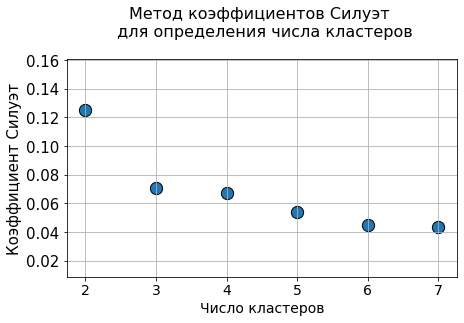

In [131]:
#выбираем оптимальное число кластеров
plt.figure(figsize=(7,4))
plt.title("Метод коэффициентов Силуэт \n для определения числа кластеров\n",fontsize=16)
plt.scatter(x=[i for i in range(2,8)],y=km_silhouette,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Число кластеров",fontsize=14)
plt.ylabel("Коэффициент Силуэт",fontsize=15)
plt.xticks([i for i in range(2,8)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

**Вывод:** Для выбора оптимального числа кластеров применили 5 различных методов. "Метод Локтя" на представленной выборке не дал результатов. Иерархический метод "complete" выявил 7 кластеров.

Остальные 3 метода (иерархические "single" и "ward", а также коэффициент "Силуэт" для кластеризации методом К-средних) выявили оптимальное число кластеров - 2.

Приходим к выводу, что оптимально проводить Кластеризацию датасета с разбиением на 2 кластера.

### Сравнение кластерных групп<a id="compare_clusters"></a>

In [132]:
#рассчитаем кластеры методом К средних

# задаём модель k_means с числом кластеров 2
cluster = KMeans(n_clusters = 2, random_state=42)

# прогнозируем кластеры для наблюдений
labels = cluster.fit_predict(X_sc)

# сохраняем метки кластера
df['cluster'] = labels

# статистика по средним значениям признаков по кластеру
cluster_mean = df.groupby('cluster').mean()

In [133]:
#Процентное разделение респондентов по класстерам
df['cluster'].value_counts()

1    546
0    516
Name: cluster, dtype: int64

Группы распределены равномерно по количеству участников

### Сравнение кластерных групп по ответам на вопросы о жизненных ценностях

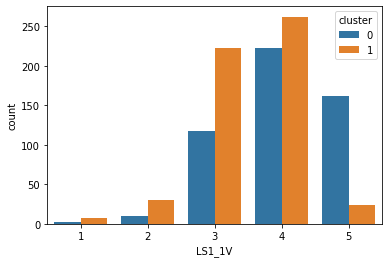

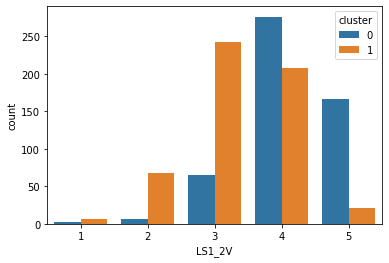

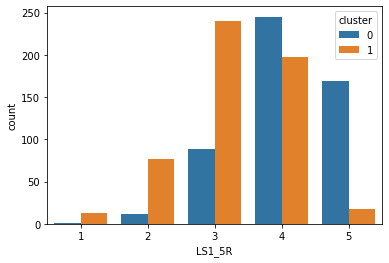

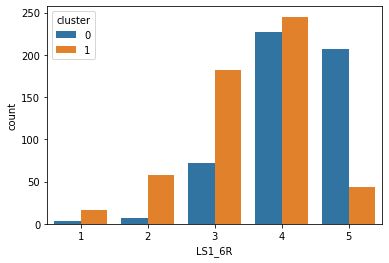

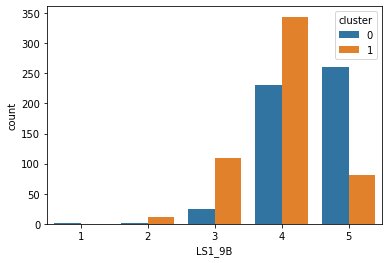

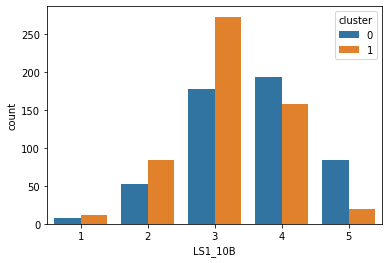

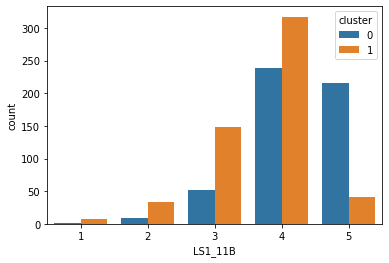

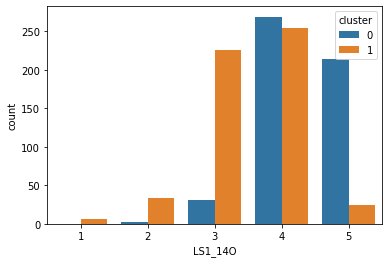

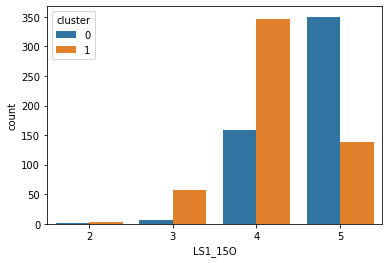

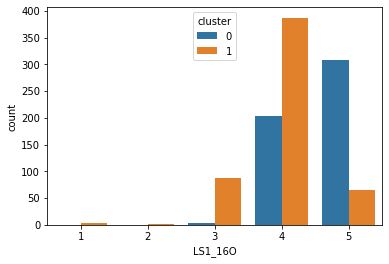

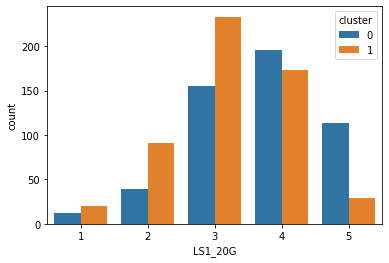

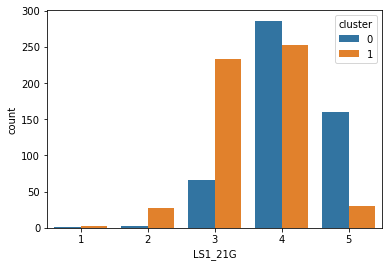

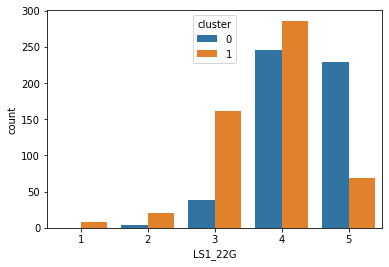

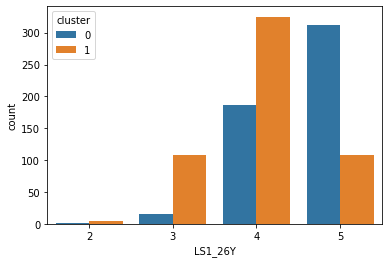

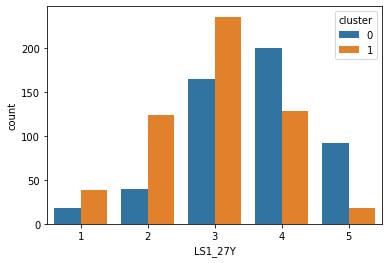

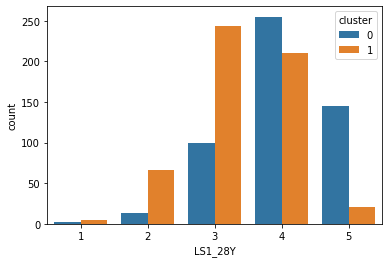

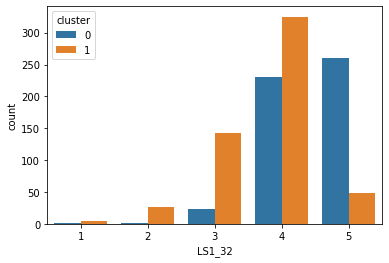

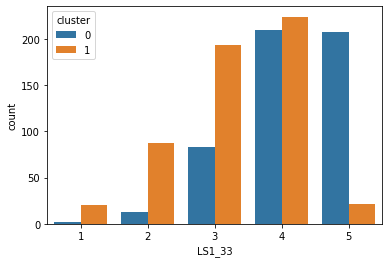

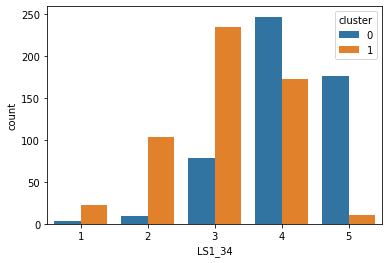

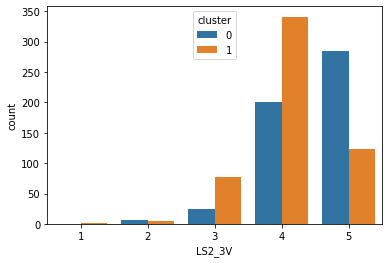

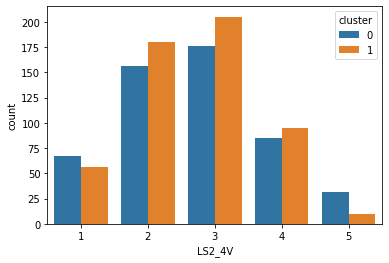

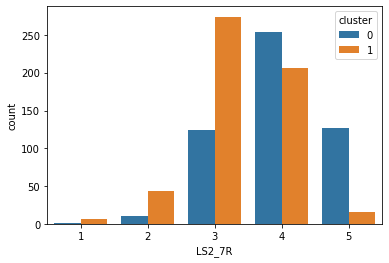

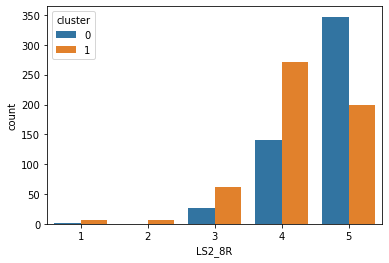

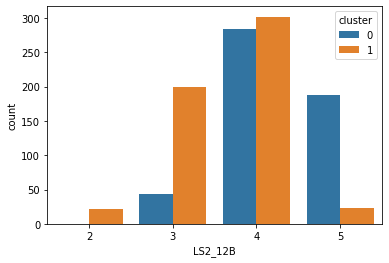

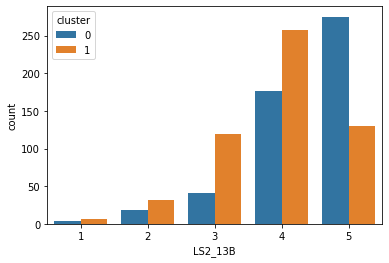

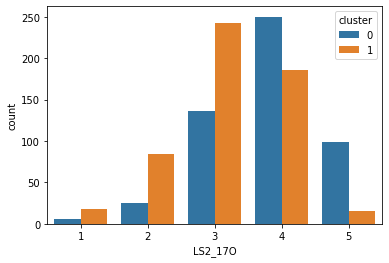

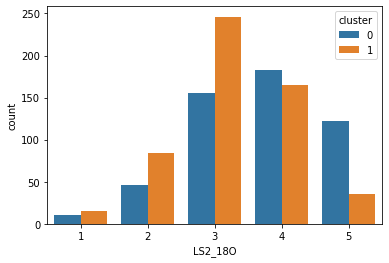

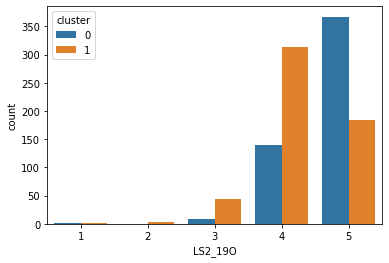

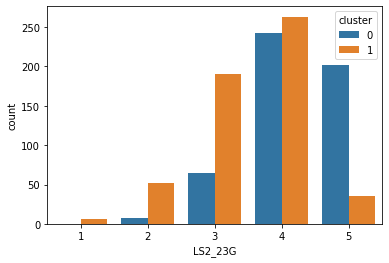

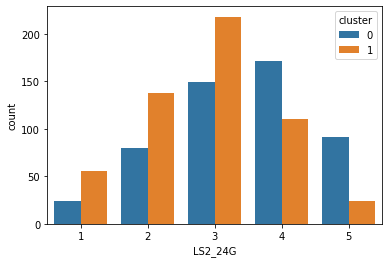

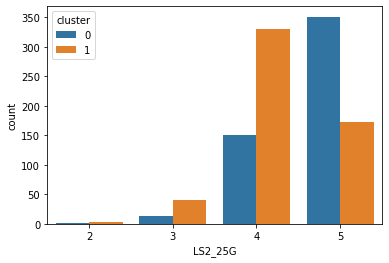

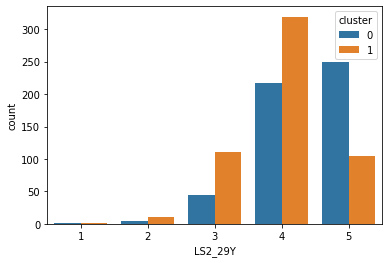

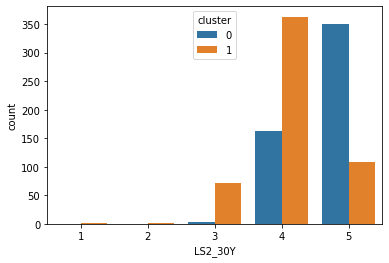

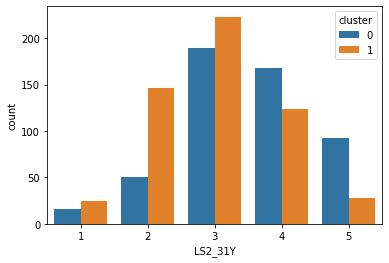

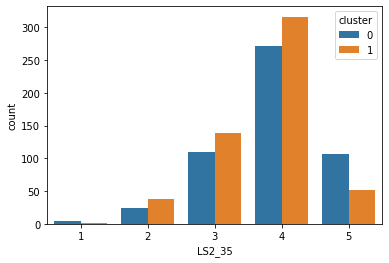

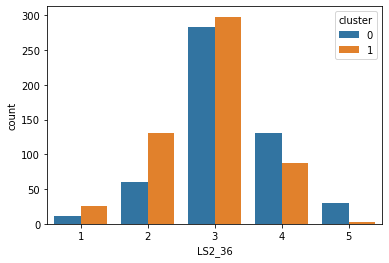

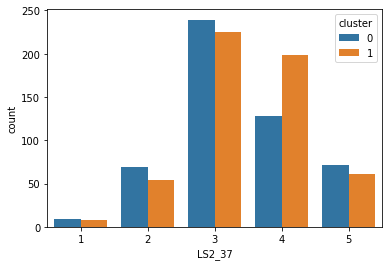

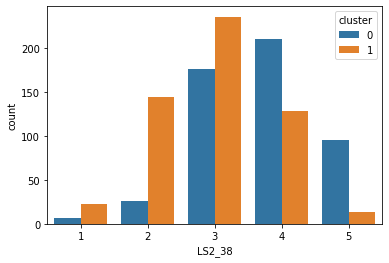

In [134]:
# распределение оценок Lifestyle по кластерам
for col in list_columns:
    sns.countplot(x=col, data=df, hue='cluster')
    plt.title = col
    plt.show()

Пользователи из кластера 0, чаще использовали в своих ответах "несогласие", практически не использовали "максимального согласия" ни в одном из вопросов о жизненных ценностях.

А вот пользователи Кластера 1 наоборот - показали ярко положительную реакцию на предложенные выражения о жизненных ценностях, часто для ответов использователи ответ "Совершенно согласен", который совсем не используют для выражения эмоций пользователи кластера 0.

Образно можно поделить эти 2 группы на "Пессимистов" и "Оптимистов" по эмоциаональной реакции на предложенные выражения.

Найдем по каким вопросам, самые значительные расхождения, для этого сравним средние оценки по каждому выражению:

In [135]:
ls_compare_cluster = df.groupby('cluster')[list_columns].mean().transpose()
ls_compare_cluster['gap'] = abs(ls_compare_cluster[0]-ls_compare_cluster[1])
ls_compare_cluster.sort_values('gap', ascending=False).head()

cluster,0,1,gap
LS1_34,4.125969,3.082418,1.043551
LS1_33,4.180233,3.258242,0.921991
LS1_14O,4.346899,3.472527,0.874372
LS1_5R,4.102713,3.239927,0.862786
LS1_2V,4.156977,3.311355,0.845621


**Вывод:** Оценки выражений пользователей кластера 1 в среднем выше, чем у пользователей кластера 0. 

По эмоциональной реакции на вопросы о жизненных ценностях кластеры можно образно обозначить:

- "Оптимисты"
- "Пессимисты"

Выражения, по которым кластерные группы наибольшим образом отличаются друг от друга:

- Я люблю посещать модные современные места
- Я люблю покупать модные вещи, марки
- Продвижение вперед в жизни Важно для меня. Я стремлюсь все делать лучше, чем другие.
- Я хочу всегда быть тем, кто принимает решения
- Я внимательно слежу за своим здоровьем, потому что боюсь заболеть

### Сравнение кластерных групп по визуальному восприятию

Изучим, как влияют жизненные ценности на визуальное восприятие. Так как визуальный контент состоит из разных наборов  картинок для категорий "Мамы" и "Женщины", то по каждому кластеру необходимо узнать выбор пользователей этих категорий.

In [136]:
col_rank1.append('cluster')

In [137]:
#  "Женщины - кластер 0"

#выборка числовых рангов картинок (категория "женщины") 
rank1_cluster0 = df.query('CellGen == "Женщины"&cluster==0')[col_rank1]
rank1_cluster0.mean().sort_values(ascending=False).head(7)

rank1_48    8.595648
rank1_58    6.414079
rank1_9     6.360517
rank1_33    5.139523
rank1_8     4.793366
rank1_47    3.652922
rank1_57    2.698196
dtype: float64

In [138]:
#  "Женщины - кластер 1"
#выборка числовых рангов картинок (категория "женщины") 
rank1_cluster1 = df.query('CellGen == "Женщины"&cluster==1')[col_rank1]
rank1_cluster1.mean().sort_values(ascending=False).head(7)

rank1_48    8.103241
rank1_9     6.926345
rank1_58    5.060031
rank1_8     4.831506
rank1_33    4.484817
rank1_47    4.302898
rank1_51    2.734959
dtype: float64

**Различия в визуальном выборе "Женщин" из разных кластеров обнаружены! **

- первая картинка в рейтинге у обеих групп совпадает, но средний ранг отличается почти на единицу.
- начиная со второго места картинки рейтинга идут в различном порядке
- закрывает оба рейтинга разные картинки "rank1_57" в нулевом кластере и "rank_51" в 1м.


In [139]:
top7_women_cluster0 = rank1_cluster0.mean().sort_values(ascending=False).head(7).index
top7_women_cluster1 = rank1_cluster1.mean().sort_values(ascending=False).head(7).index

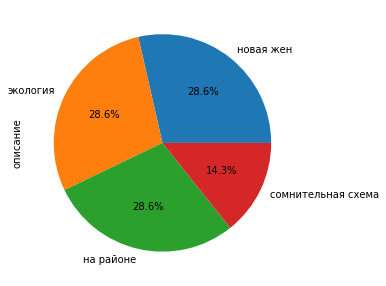

In [140]:
# Распределение трендов у "Женщин" кластера 0
trends1.query('rank_name in @top7_women_cluster0')['описание'].value_counts().plot(kind='pie', figsize=(5,5), autopct='%1.1f%%');

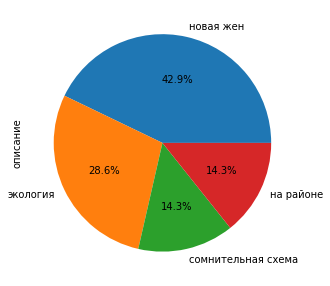

In [141]:
# Распределение трендов у "Женщин" кластера 1
trends1.query('rank_name in @top7_women_cluster1')['описание'].value_counts().plot(kind='pie', figsize=(5,5), autopct='%1.1f%%');

**Различия по предпочитаемым трендам среди женщин разных кластерных групп:**
    
- Предпочтения по трендам женщин из кластера 1 равномерно распределились между 3мя трендами: "экология", "новая жен" и "на районе"
- У женщин кластера 0 определился явный лидер-тренд - "новая жен" 

In [142]:
#  "Мамы - кластер 0"

#выборка числовых рангов картинок (категория "женщины") 
rank2_cluster0 = df.query('CellGen == "Мамы"&cluster==0')[col_rank2]
rank2_cluster0.mean().sort_values(ascending=False).head(7)

rank2_36    3.859817
rank2_14    3.331484
rank2_42    3.309556
rank2_17    3.061201
rank2_13    2.874817
rank2_58    2.786207
rank2_11    2.652524
dtype: float64

In [143]:
#  "Мамы - кластер 1"

#выборка числовых рангов картинок (категория "женщины") 
rank2_cluster1 = df.query('CellGen == "Мамы"&cluster==1')[col_rank2]
rank2_cluster1.mean().sort_values(ascending=False).head(7)

rank2_36    4.653865
rank2_11    3.988124
rank2_17    3.722081
rank2_42    3.446003
rank2_38    3.366527
rank2_12    3.152981
rank2_14    2.943281
dtype: float64

Похожая история и с "Мамами":

- картинка с наибольшим рейтингом совпадает
- последовательность картинок в рейтинге, начиная со второй позиции отличается у "Мам" из разных кастеров.

In [144]:
top7_children_cluster0 = rank2_cluster0.mean().sort_values(ascending=False).head(7).index
top7_children_cluster1 = rank2_cluster1.mean().sort_values(ascending=False).head(7).index

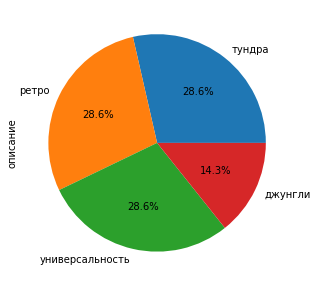

In [145]:
# Распределение трендов у "Мам" кластера 0
trends2.query('rank_name in @top7_children_cluster0')['описание'].value_counts().plot(kind='pie', figsize=(5,5), autopct='%1.1f%%');

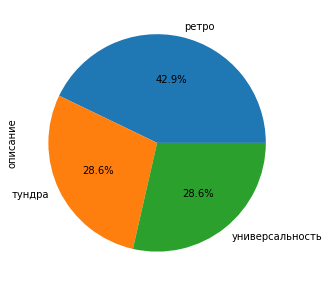

In [146]:
# Распределение трендов у "Мам" кластера 1
trends2.query('rank_name in @top7_children_cluster1')['описание'].value_counts().plot(kind='pie', figsize=(5,5), autopct='%1.1f%%');

**Различия по предпочитаемым трендам среди "мам" разных кластерных групп:**
    
- Предпочтения по трендам мам из кластера 1 равномерно распределились между 3мя трендами: "тундра", "универсальность" и "ретро"
- У мам кластера 0 лидер-тренд - "ретро". И совсем отсутствует в топе тренд "Джунгли" 

### Сравнение групп по демографическим признакам

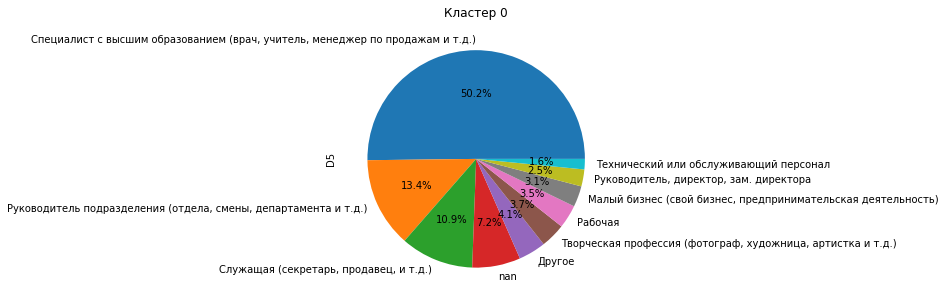

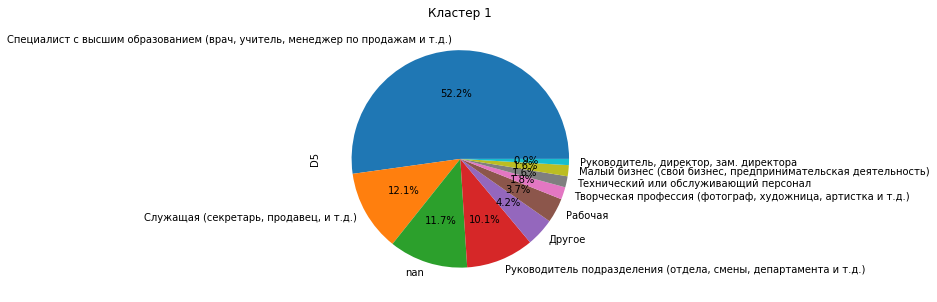

In [147]:
#вид деятельности
cluster_job = df.pivot_table(index=['age'], columns=['cluster'], values='InterviewID', aggfunc='count')

for col in cluster_job.columns:
    df.query('cluster == @col')['D5'].value_counts().plot(kind='pie', figsize=(5,5), autopct='%1.1f%%', title='Кластер '+str(col));
    plt.show()

По роду деятельности оба кластера на 50% состоят из специалистов с высшим образованием (врач, учитель, менеджер и т.д.). Поэтому состредоточимся на различии в составе кластеров по роду деятельности оставшейся половины респондентов в каждой группе:

- В кластере 1 на 37% больше женщин на руководящих постах и творческих профессиях, чем в кластере 0 

- В кластере 1 в процентном соотношении "Домохозяек" в 2 раза меньше, чем в кластере 0.

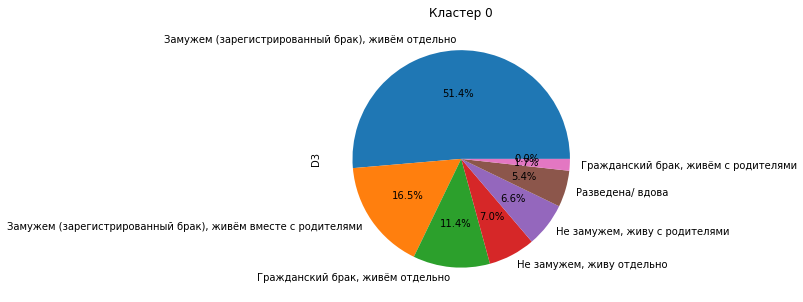

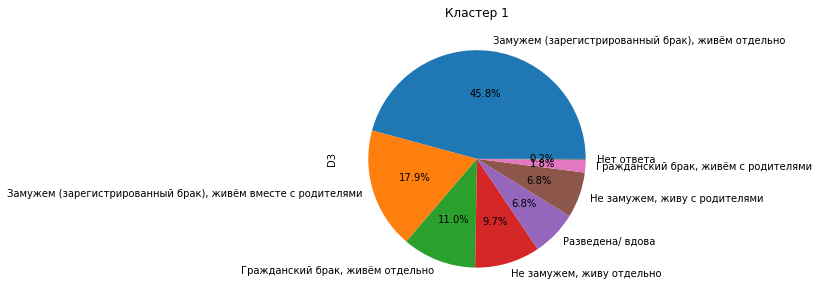

In [148]:
#семейное положение
family_cluster = df.pivot_table(index=['D3'], columns=['cluster'], values='InterviewID', aggfunc='count')

for col in family_cluster:
    df.query('cluster == @col')['D3'].value_counts().plot(kind='pie', figsize=(5,5), autopct='%1.1f%%', title='Кластер '+str(col));
    plt.show()

По "семейному положению" между кластерами не найдено существенных различий.

In [149]:
#материальное положение
df.pivot_table(index=['D10'], columns=['cluster'], values='InterviewID', aggfunc='count')

cluster,0,1
D10,,
"Денег хватает на все, кроме покупки недвижимости (дачи или квартиры)",100.0,61.0
"Денег хватает на крупную бытовую технику, но мы не могли бы купить новую машину",244.0,237.0
"Денег хватает на питание, одежду и мелкую бытовую технику, но купить сейчас телевизор, холодильник или стиральную машину",134.0,221.0
Затрудняюсь ответить,7.0,12.0
"Материальных затруднений не испытываем. При необходимости могли бы приобрести дачу, квартиру",25.0,4.0
"На питание денег хватает, но покупка одежды вызывает затруднения",6.0,9.0
Нам не хватает денег даже на питание,NaN,2.0


Различия между кластерами в признаке "Материальное положение":

- Респонденты из кластера 1 в 6 раз чаще выбирали максимальный вариант ответа на вопрос о материальном положении (могут позволить себе приобретение недвижимости), чем респонденты из кластера 0.
- Второй по материальному уровню ответ (позволить могут все, кроме недвижимости) также респонденты из кластера 1 составили большинство (опередили кластер 0 на 40%)

Делаем вывод, что респонденты кластера 1 в целом имеют выше материальный доход, чем группа кластера 0. 

Наличие детей


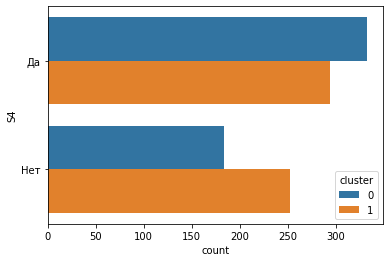

Возраст


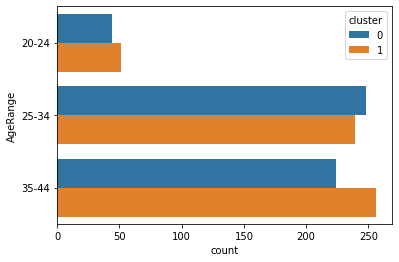

Сколько человек в семье


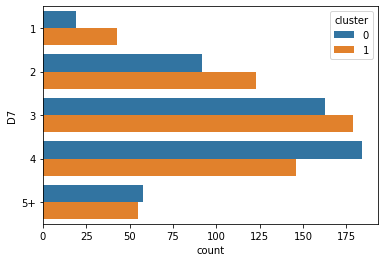

Число детей


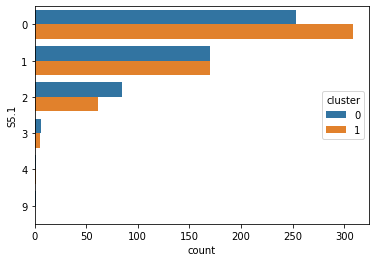

In [150]:
#графики распределения характеристик респондентов по кластерам
#построим столбчатые диаграммы по хараткристикам целевой адуитории
columns_bar = ['S4','AgeRange', 'D7', 'S5.1']
dict_demography = {'S4':'Наличие детей',
                   'AgeRange': 'Возраст',
                   'D3':'Семейное положение',
                   'D5':'Род деятельности',
                   'D10':'Уровень дохода',
                  'D7': 'Сколько человек в семье',
                  'S5.1': 'Число детей'}

for col in columns_bar:
    #plt.figure(figsize=(8,5), dpi= 80)
    sns.countplot(orient = "h", y=col, data=df, hue='cluster')
    print(dict_demography[col])
    plt.show()

Кластер 1 это женщины с детьми, которые чаще имеют семью из 3-4 человек, являются мамами 1-2 детей.
Кластер 0 наоборот содержит больше в процентном соотношении одиноких женщин без детей.

По возрасту есть небольшие различия (Кластер 1 - больше женщин в категории 25-34, а в кластере 0 - больше женщин старше 35 лет). Различия по возрасту незначительные, чтобы учитывать в описании кластеров. 

**Вывод:**

Кластеризация респондентов по вопросам жизненных ценностей определила 2 группы целевой аудитории, по некоторым признакам кластеры имеют характерные различия:

- **"Специалисты в своей области"**: домохозяйки, студентки, специалисты с высшим образованием в подчинении. Также группа отличается более низким материальным уровнем.

- **"Креативные лидеры"**: руководители разного ранга, предприниматели, представительницы творческих профессий. Группа выделяется более высоким материальным положением. Процент родителей в данном кластере выше, чем в смежном.

## Вывод и рекомендации<a id="summary"></a>

Тренд сезона - расслабленное настроение, спокойная гамма, свободный крой!

**Выбор графических паттернов:**

У категории "Женщины" все неоднозначно с модными предпочтениями. По распределению ранговых оценок к показанным картинкам респондентам заметили больший разброс значений, чем в категории "Мамы", у которых оценки визуального контента имеют более равномерный характер.

Возможно, это связано с тем, что категория "Женщины" требует дополнительной разбивки на целевые группы.

**Вопросы LifeStyle:**

Некоторые вопросы в разделе LifeStyle значительно коррелируют между собой. Есть пары вопросов, которые частично дублируют друг друга по смыслу:

- "Я люблю покупать модные марки-вещи" / "Я люблю модные современные места"

- "Я предпочитаю вести здоровый образ жизни" / "Я внимательно слежу за своим здоровьем, потому что боюсь заболеть"

Также в анкете присутствуют вопросы, формулировка которых заставляет отвечать положительно подавляющее большинство респондентов. Такие выражения не характеризуют или слабо характеризуют аудиторию. Например, выражение "Лучше быть богатым и здоровым, чем бедным и больным" с высокой вероятностью получит максимальное согласие от всех категорий опрашиваемых, не зависимо от их жизненых ценностей. В представленной анкете таким вопросом стал: "Я хочу наслаждаться жизнью по-настоящему и хорошо проводить время". Градиция ответов по нему была ограниченная, минимальный балл не поставил ни один человек из опрашиваемых.

**Кластеризация респондентов по жизненным ценностям:**

Среди 1000 опрошенных по заданным вопросам о жизненных ценностях, мы выделили 2 группы:

**"Креативные лидеры"**: 

- В составе кластера на 1/3 больше респондентов занимают руководящие должности или являются представителями творческих профессий, а также в 2 раза меньше Домохозяек, чем в противоположном кластере.
- Имеют выраженный "Оптимистичный" взгляд на жизнь, любят модные вещи и места, стремятся к победе, стараются быть лучшими во всем  
- При выборе визуального контента группа неоднородна в выборе популярного тренда. Топовых трендов - 3.
- Имеют высокое материальное положение
- Чаще имеют полную семью в составе 3-4 человека

**"Специалисты в своей области"**:

- В составе кластера больше домохозяек, студенток, специалистов с высшим образованием в подчинении.
- Материальный уровень средний
- Предпочтение трендов однородное, предсказуемое по кластеру. Как в категории "Женщины", так и в категории "Мамы" выделен один явный тренд-лидер.

**В результате исследования увидели, что различные жизненные ценности влияют на визуальный выбор респондентов. Однородность выбора тренда кластера "Домохозяек", говорит о том, что эта группа более консервативна в своем выборе, подвержена массовой моде, единому тренду. Гораздо сложнее уловить модные тенденции группы "Креативных лидеров".**